##### this notebook reads real point cloud data and generate some statistics from point cloud. these statistics  are descriptable features of point clouds. These point clouds are our templates. for classifying new point cloud its enough to compare it with templates.
##### then generate a point cloud with gaussian distribtion. Finally compare statistics of this point cloud with templates.

In [5]:
import importlib.util

package_name = 'trimesh'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install trimesh
else:
    print(package_name +" is installed")

trimesh is installed


In [6]:
package_name = 'mahotas'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install mahotas
else:
    print(package_name +" is installed")

mahotas is installed


In [7]:
import numpy as np
import math
import cv2
import pandas as pd
import mahotas
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import regionprops
from skimage.transform import rescale, resize
from skimage.morphology import thin
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from matplotlib.ticker import MultipleLocator
from utils import dataset_loader, my_utils, Operations, Moments, generate_point_cloud
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

## load dataset from specific directory


In [9]:
surface     = ['FOCTS', 'PEG', 'ODS']
temperature = 24
load_NIPAM  = False
DATA_DIR    = "../../dataset/Dataset"
dataset_dictionary  = dataset_loader.get_dataset(DATA_DIR = DATA_DIR, temperature = temperature, surface =surface, load_NIPAM = load_NIPAM, Flag_zreverse = True)

FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/Dataset'

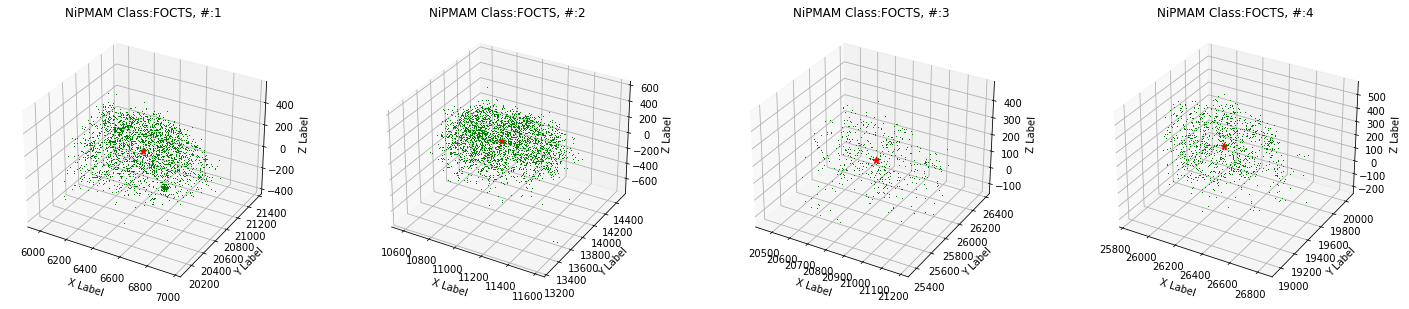

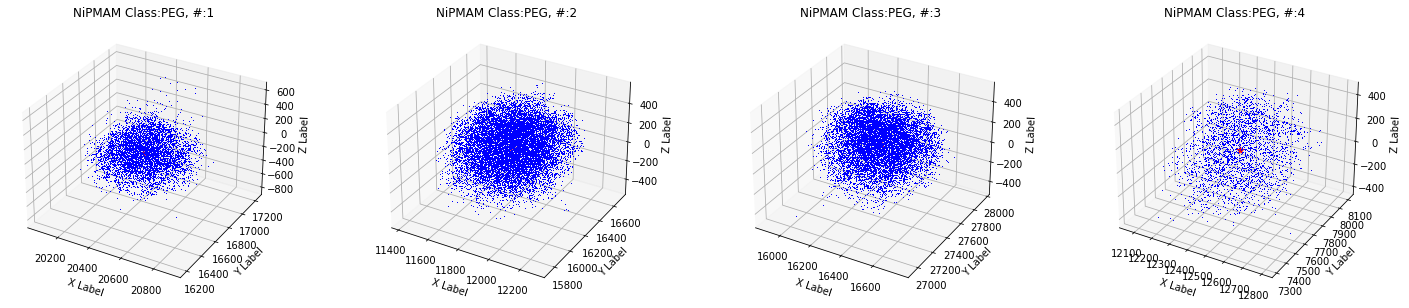

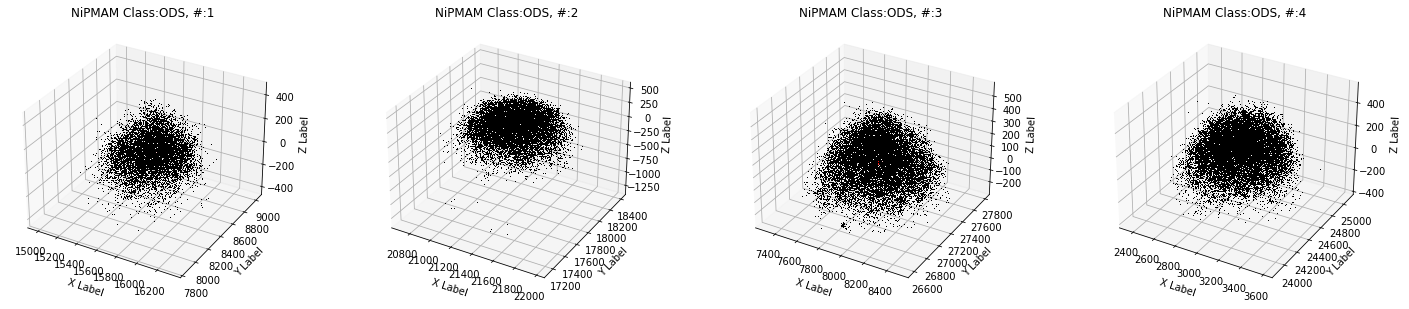

In [8]:
sample_per_class = 4
my_utils.visualize_list_point_clouds(dataset_dict = dataset_dictionary, sample_per_class = sample_per_class)

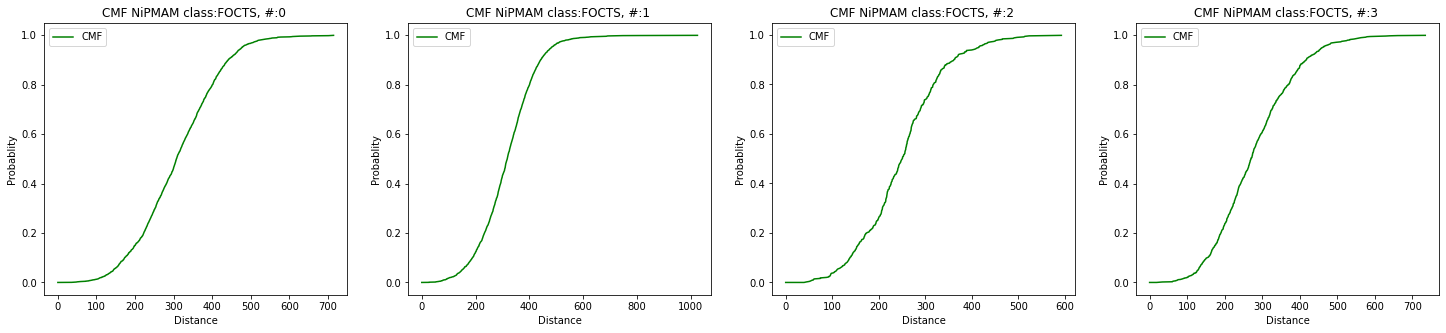

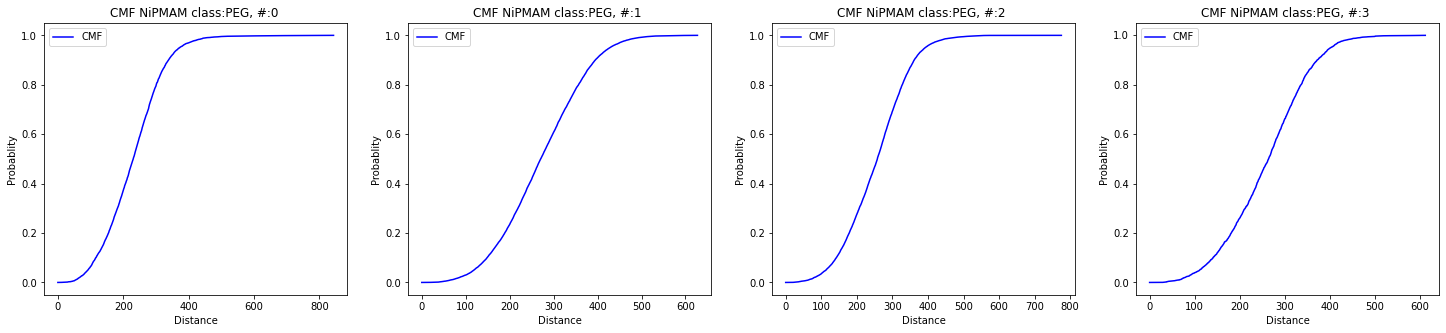

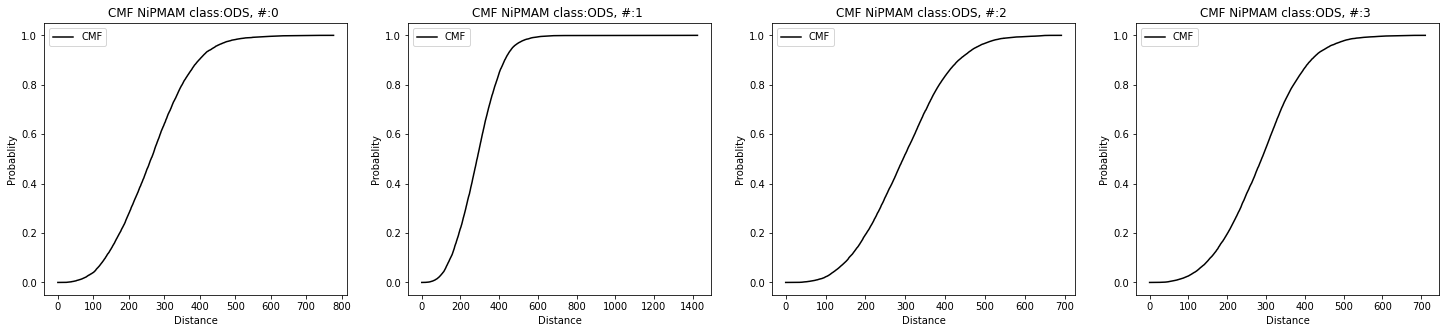

In [9]:
sample_per_class = 4
all_cmf = my_utils.depict_cmf(dataset_dict = dataset_dictionary, sample_per_class = sample_per_class)

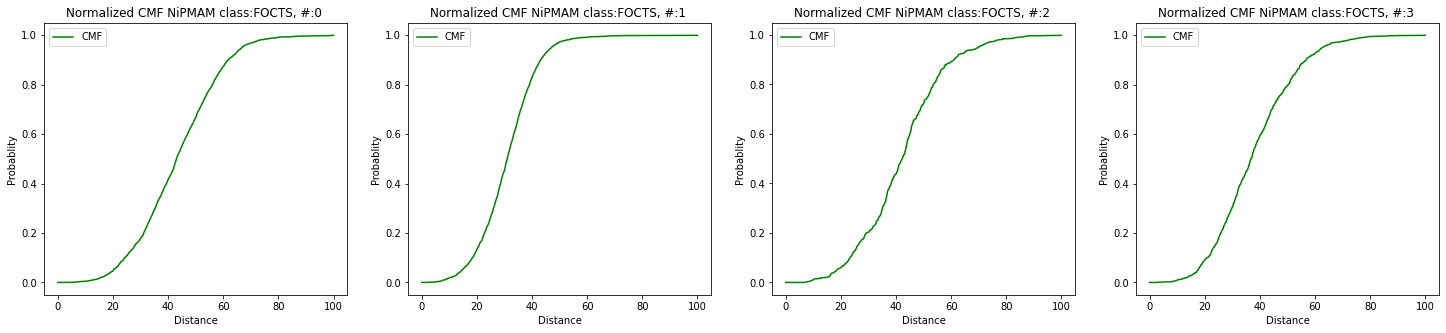

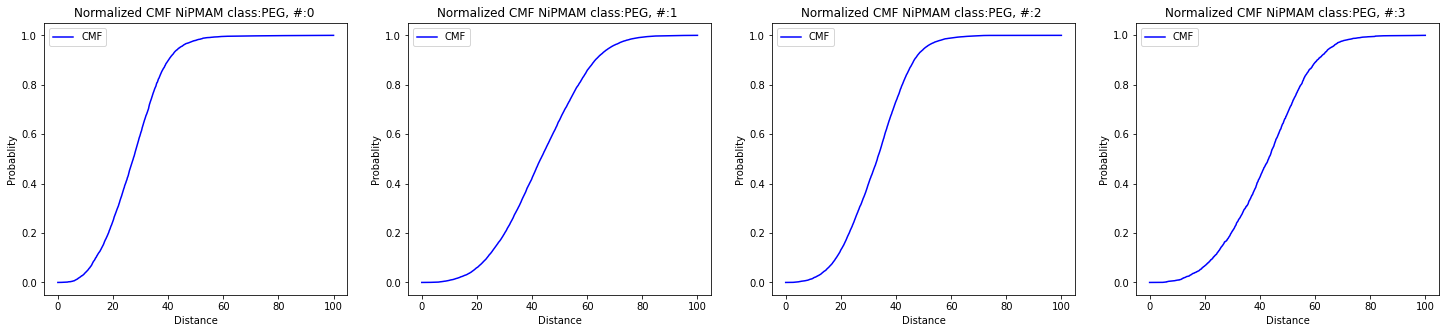

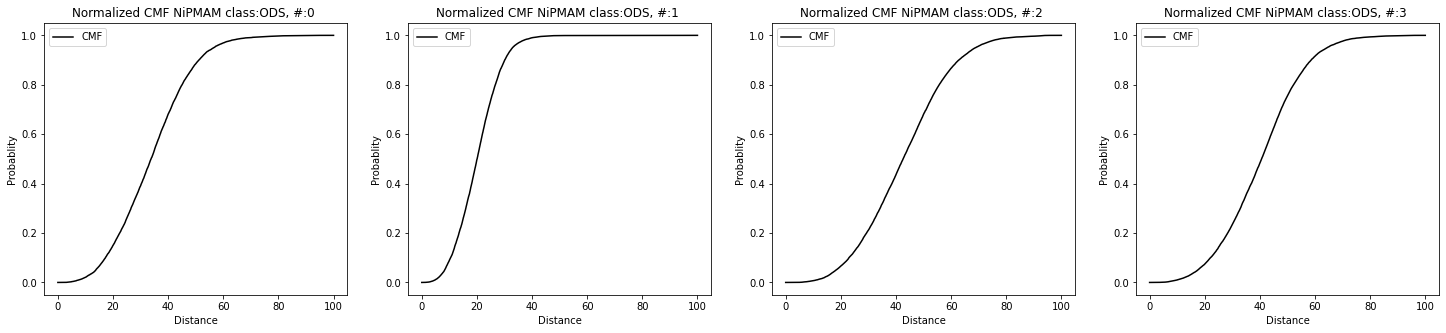

In [10]:
sample_per_class = 4
all_cmf_normalize= my_utils.depict_normalzed_cmf(dataset_dict = dataset_dictionary, sample_per_class = sample_per_class)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


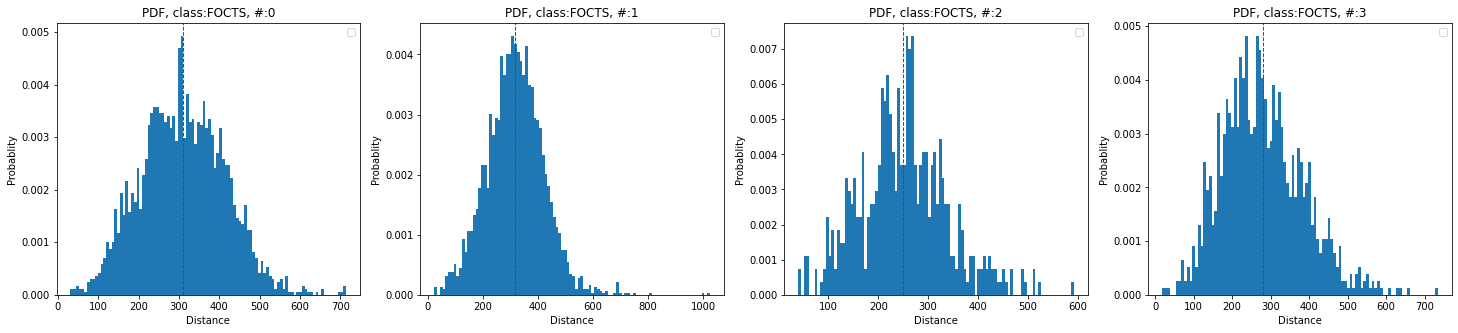

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


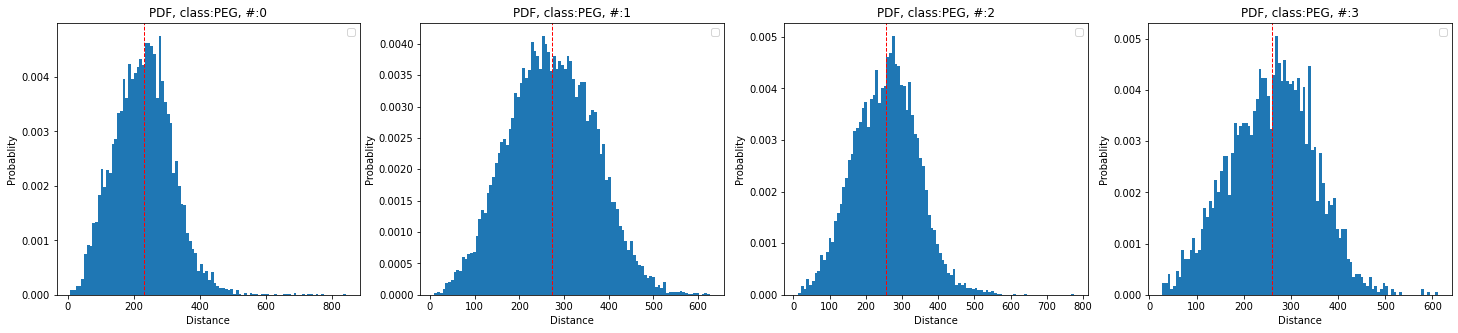

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


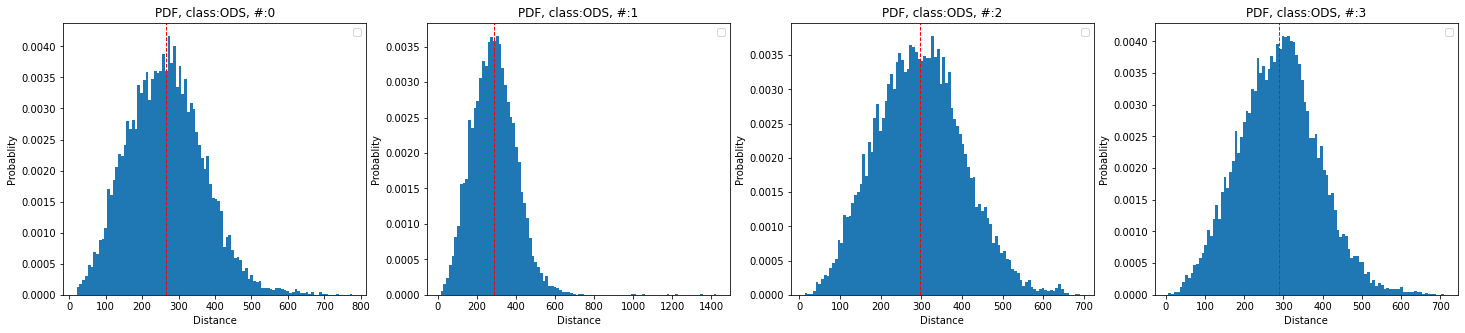

In [11]:
sample_per_class = 4
my_utils.depict_pdf(dataset_dict = dataset_dictionary, sample_per_class = sample_per_class)

## CMF for 99% confidency from center

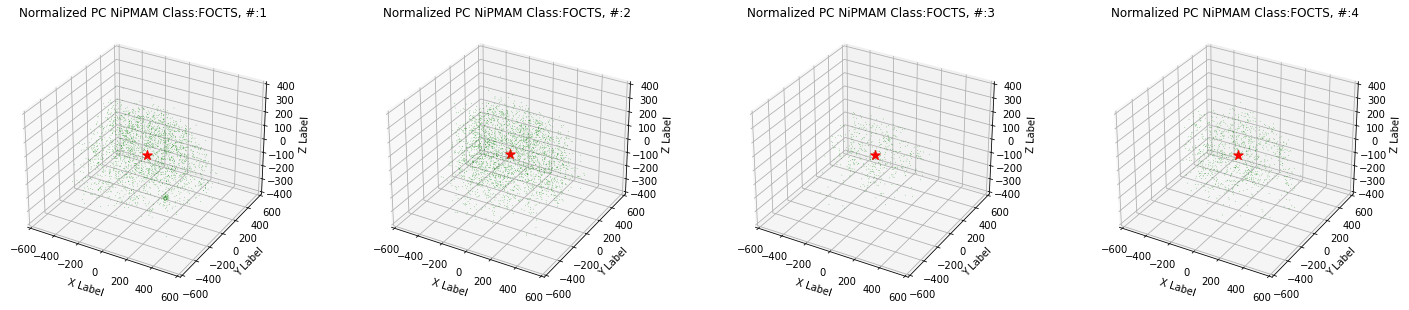

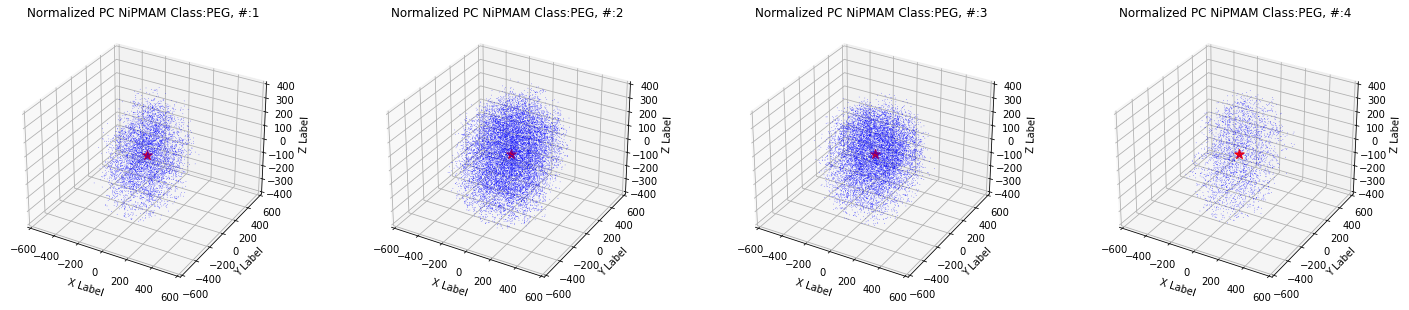

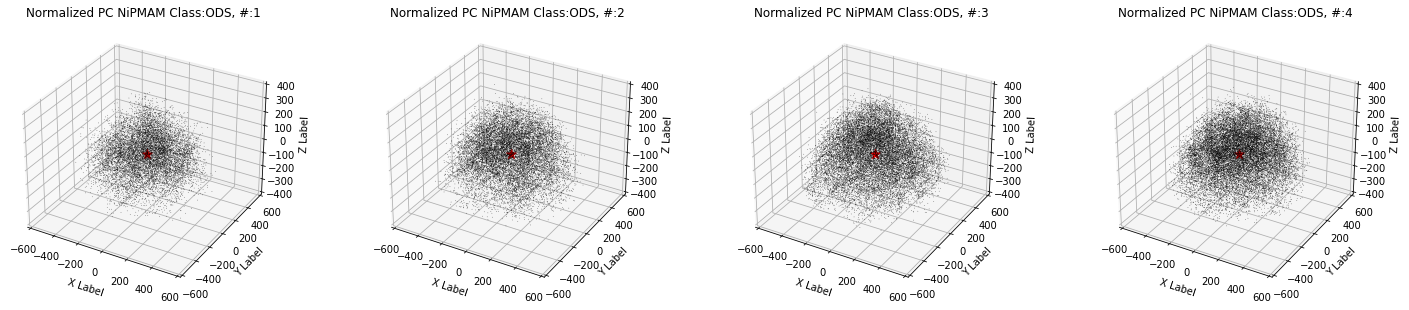

In [12]:
confidence   = 0.99
do_normalize = True
normalized_dataset_dict = my_utils.Refine_PC(dataset_dict = dataset_dictionary, sample_per_class = sample_per_class,
                                             confidence = confidence, do_normalize = do_normalize)

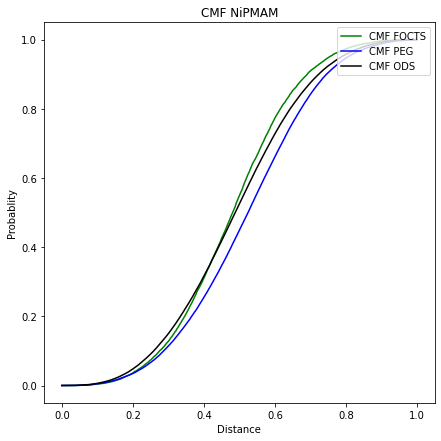

In [13]:
normalized_dataset_dict_grouped = my_utils.depict_cmf_group_aggregation(dataset_dict = normalized_dataset_dict)

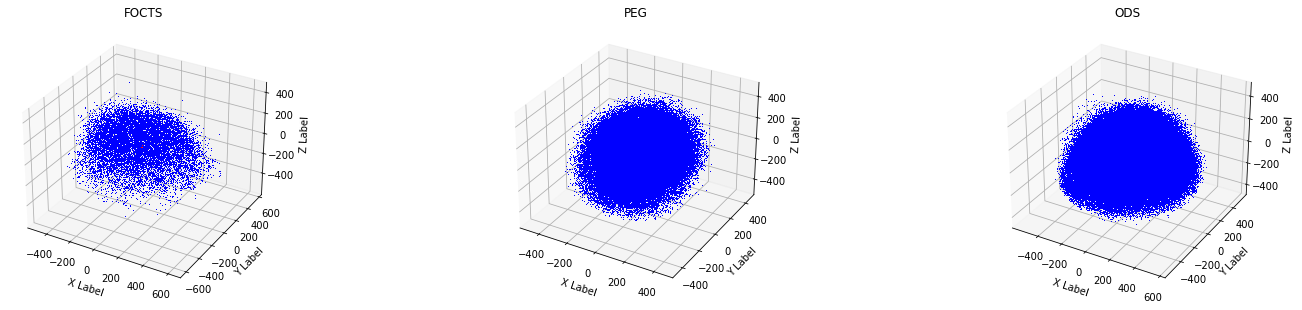

In [15]:
fig = plt.figure(figsize=(25,5))
surface = ['FOCTS', 'PEG', 'ODS']
for idx, surf in enumerate(surface):
    ods = normalized_dataset_dict_grouped[surf][0]
    mue = np.mean(ods, axis=0)
    ax1 = fig.add_subplot(1, 3, idx+1, projection="3d")
    ax1.scatter(ods[:, 0], ods[:, 1], ods[:, 2], s=1, c='blue', marker="s", facecolor="red", lw=0, alpha=1)
    ax1.scatter(mue[0], mue[1], mue[2], s=50, c='r', marker="*", )
    ax1.set_xlabel('X Label')
    ax1.set_ylabel('Y Label')
    ax1.set_zlabel('Z Label')
    ax1.set_title(surf)

  





In [68]:
np.max(ods[:, 1])

534.3698987340122

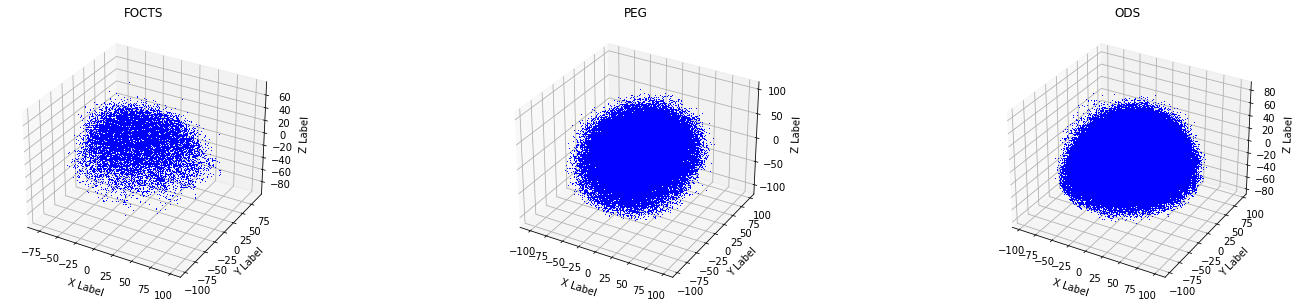

In [16]:
fig = plt.figure(figsize=(25,5))
surface = ['FOCTS', 'PEG', 'ODS']
for idx, surf in enumerate(surface):
    ods = normalized_dataset_dict_grouped[surf][0]
    ods = ods/ods.max() * 100
    mue = np.mean(ods, axis=0)
    ax1 = fig.add_subplot(1, 3, idx+1, projection="3d")
    ax1.scatter(ods[:, 0], ods[:, 1], ods[:, 2], s=1, c='blue', marker="s", facecolor="red", lw=0, alpha=1)
    ax1.scatter(mue[0], mue[1], mue[2], s=50, c='r', marker="*", )
    ax1.set_xlabel('X Label')
    ax1.set_ylabel('Y Label')
    ax1.set_zlabel('Z Label')
    ax1.set_title(surf)

In [17]:
def calc_dist(p, mue): 
    """    
    At first, minus mue from point clouds, then calculate square 2 of them
     Args:
         p:   point cloud
         mue: mean of point cloud
    
    returns: calculated distance
    """
    return np.linalg.norm(p-mue, 2)
from tqdm import tqdm

p_sep = np.arange(-100, 101, 20)
points = normalized_dataset_dict['FOCTS'][0]
points = points/points.max() * 100

t = 1
TH = 100
Values = []
for xp in tqdm(p_sep):
    for yp in p_sep:
        for zp in p_sep:
            mue = [xp, yp, zp]
            sorted_dists   = sorted([calc_dist(p, mue) for p in points])
            for j, d in enumerate(sorted_dists):
                if sorted_dists[j]>TH:
                    break
            Values.append(np.array(sorted_dists[:j]).sum())
            
                


100%|██████████| 11/11 [01:47<00:00,  9.77s/it]


In [18]:
cord3d = []
S      = []
idx    = 0
for xp in tqdm(p_sep):
    for yp in p_sep:
        for zp in p_sep:
            cord3d.append([xp, yp, zp])
            S.append(Values[idx])
            idx += 1

cord3d = np.array(cord3d)            
S = np.array(S)
S = S/ S.max()
S = S * 100

100%|██████████| 11/11 [00:00<00:00, 10850.74it/s]


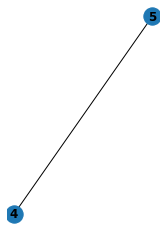

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
# G = nx.petersen_graph()
G.add_nodes_from([

    (4, {"color": "red"}),

    (5, {"color": "green"}),

])
G.add_edge(4, 5)

# e = (2, 3)

# G.add_edge(*e)  # unpack edge tuple*
subax1 = plt.subplot(121)

nx.draw(G, with_labels=True, font_weight='bold')


In [20]:
import open3d as o3d

cord3d_th = []
TH = S.mean()
radius = 10
for idx, p in enumerate(cord3d):
    if S[idx]>TH:
        point = (p[0]+random.uniform(0, radius//2), p[1]+random.uniform(0,radius//2), p[2]+random.uniform(0, radius//2))
        cord3d_th.append(point)
cord3d_th = np.array(cord3d_th)
pos = {i: (p[0]+random.uniform(0, radius//2), p[1]+random.uniform(0,radius//2), p[2]+random.uniform(0, radius//2)) for i, p in enumerate(cord3d_th)}
print(cord3d_th.shape)
pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(cord3d_th)
o3d.visualization.draw_geometries([pointcloud])



NameError: name 'random' is not defined

In [187]:
pcd = o3d.geometry.PointCloud()
xyz = ods
xyz /= xyz.max()
pcd.points = o3d.utility.Vector3dVector(xyz)
keypoints = pcd

# keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd)
alpha = 0.007
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(keypoints, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

alpha=0.007


In [140]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [174]:
random.uniform(0, 10)

5.827126780061346

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

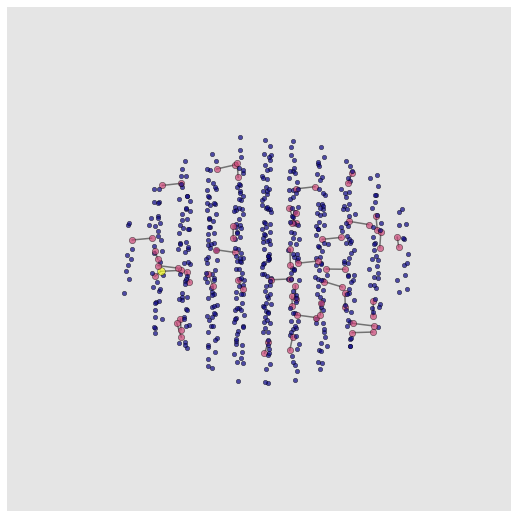

In [175]:
def generate_random_3Dgraph(n_nodes, radius, cord3do = None, S = 0, seed=None):

    if seed is not None:
        random.seed(seed)
    
    # Generate a dict of positions
    if len(cord3do):
        cord3d = []
        TH = S.mean()
        for idx, p in enumerate(cord3do):
            if S[idx]>TH:
                cord3d.append(p)
        cord3d = np.array(cord3d)
        
        pos = {i: (p[0]+random.uniform(0, radius//2), p[1]+random.uniform(0,radius//2), p[2]+random.uniform(0, radius//2)) for i, p in enumerate(cord3d)}
    else:
        pos = {i: (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)) for i in range(n_nodes)}
    
    # Create random 3D network
    G = nx.random_geometric_graph(n_nodes, radius, pos=pos)

    return G 

G = generate_random_3Dgraph(n_nodes = len(cord3d), radius = 15, cord3do = cord3d, S= S, seed=None)
network_plot_3D(G,0, save=False)



In [157]:
pos = nx.get_node_attributes(G, 'pos')

# Get number of nodes
n = G.number_of_nodes()

# Get the maximum number of edges adjacent to a single node
edge_max = max([G.degree(i) for i in range(n)])

n, edge_max
# colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

(1331, 0)

In [145]:
def network_plot_3D(G, angle, save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for i,j in enumerate(G.edges()):

            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
    ax.set_axis_off()

    if save is not False:
#         plt.savefig("C:\scratch\\data\"+str(angle).zfill(3)+".png")
        plt.close('all')
    else:
        plt.show()
    
    return

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

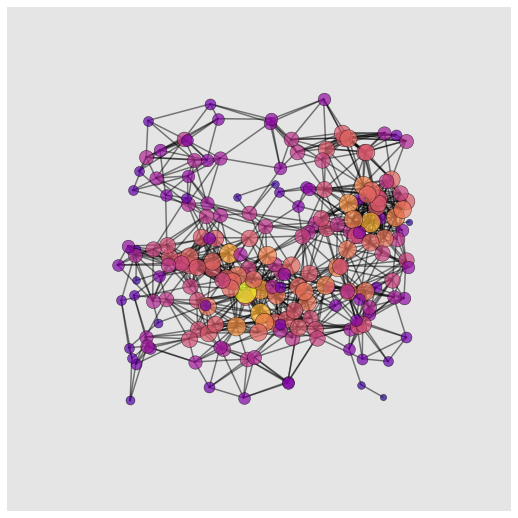

In [146]:
n=200
G = generate_random_3Dgraph(n_nodes=n, radius=0.25, seed=1)
network_plot_3D(G,0, save=False)

Text(0.5, 0.92, 'ODS')

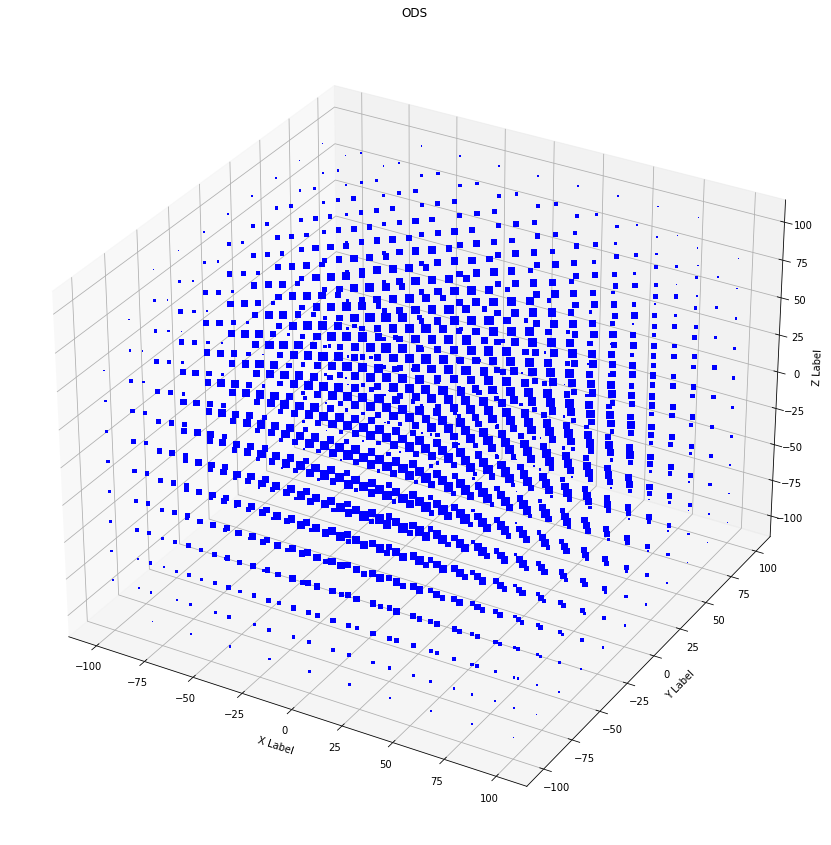

In [125]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1, 1, 1, projection="3d")
ax1.scatter(cord3d[:, 0], cord3d[:, 1],cord3d[:, 2], s=S, c='blue', marker="s", facecolor="red", lw=0, alpha=1)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title(surf)
    





In [79]:
distances

array([-100,  -95,  -90,  -85,  -80,  -75,  -70,  -65,  -60,  -55,  -50,
        -45,  -40,  -35,  -30,  -25,  -20,  -15,  -10,   -5,    0,    5,
         10,   15,   20,   25,   30,   35,   40,   45,   50,   55,   60,
         65,   70,   75,   80,   85,   90,   95,  100])

No handles with labels found to put in legend.


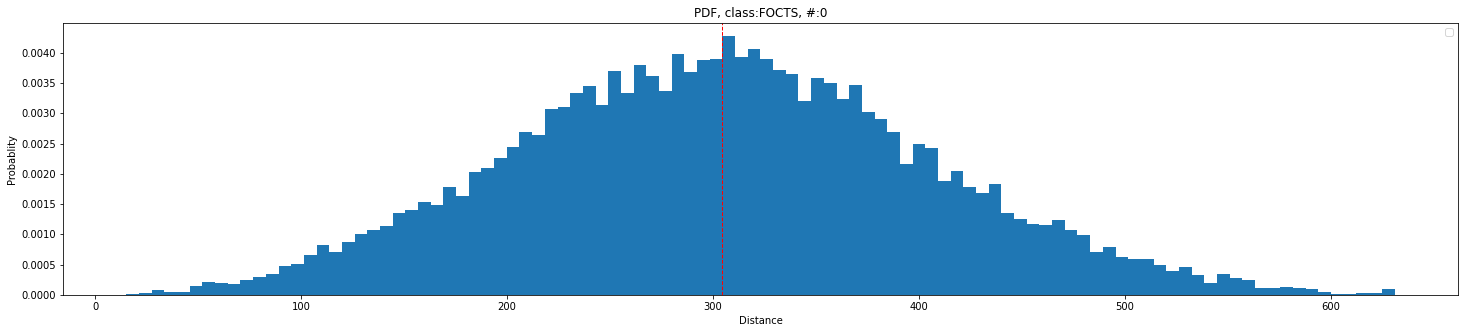

No handles with labels found to put in legend.


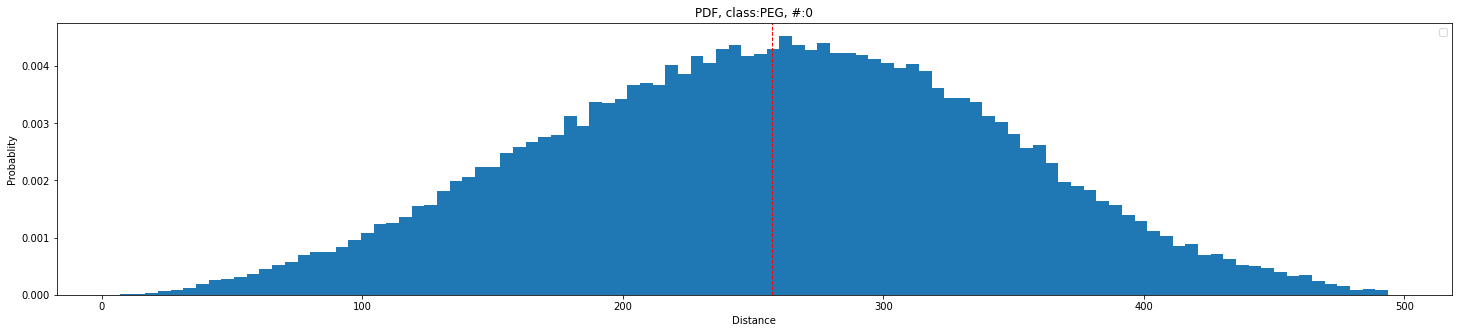

No handles with labels found to put in legend.


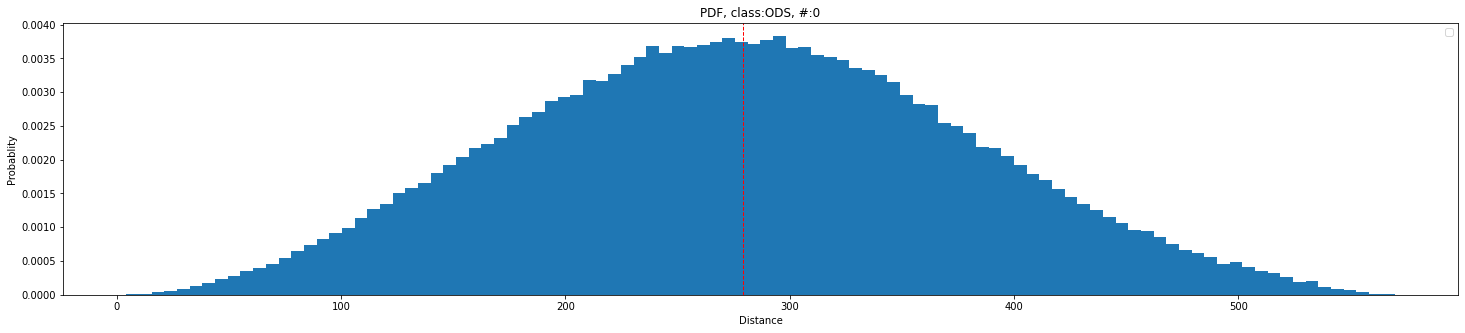

In [14]:
my_utils.depict_pdf(normalized_dataset_dict_grouped, sample_per_class = 1)

In [ ]:
DNS

## Get Features for ODS

In [19]:
number_bin = 45
all_hist_angle_ODS = Operations.histogram_angle(normalized_dataset_dict['ODS'],number_bin)

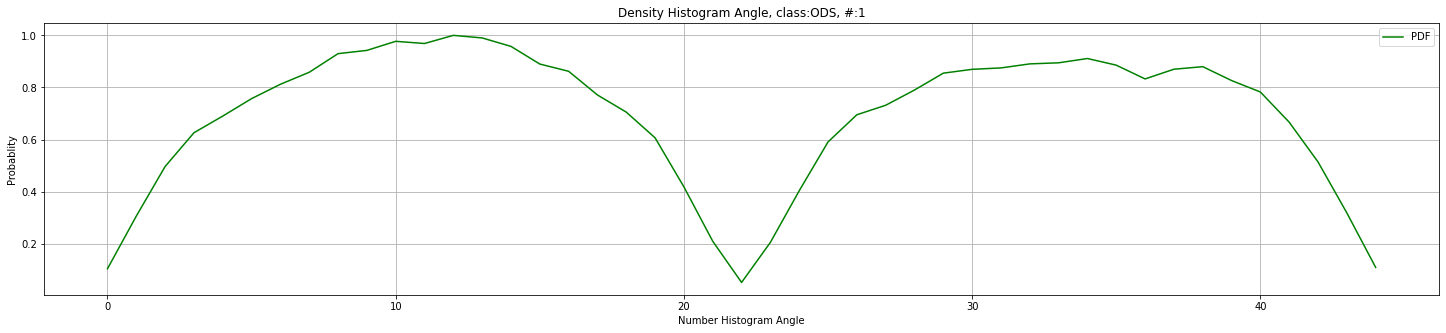

In [20]:
sample_per_class = 4
class_name       = 'ODS'
colors           = ['g','b','k','y','m','c']
number_bin       = 45
Operations.draw_histogram_angle(all_hist_angle_ODS, number_bin = number_bin, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

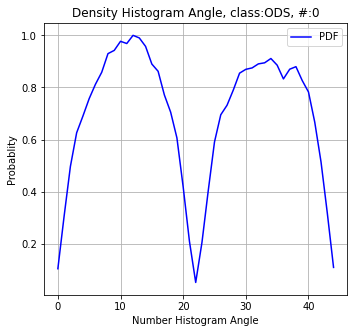

0


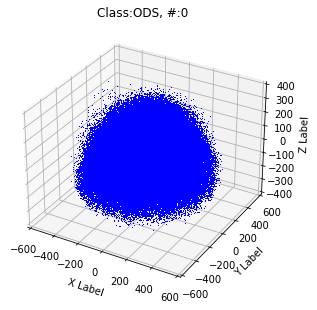

In [21]:
number_bin = 45
class_name = 'ODS'
visualize  = True
index_angle_ODS,hist_angle_mod_ODS = Operations.compare_histogram_angle(normalized_dataset_dict['ODS'], all_hist_angle_ODS, class_name = class_name, number_bin = number_bin, visualize = visualize)

In [22]:
distance_bet_radius = 10
number_rad          = 70
all_hist_radius_ODS = Operations.histogram_radius(normalized_dataset_dict['ODS'], number_rad = number_rad, distance_bet_radius = distance_bet_radius)

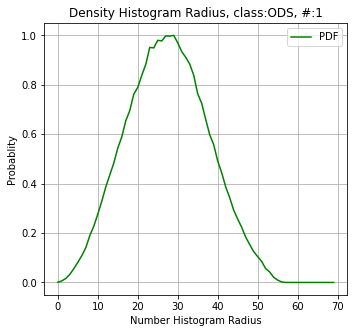

In [23]:
sample_per_class = 4
class_name       = 'ODS'
number_rad       = 70
colors           = ['g','b','k','y','m','c']
Operations.draw_histogram_radius(all_hist_radius_ODS, number_rad = number_rad, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

mod is :  0  Value is  0.9999999999999999


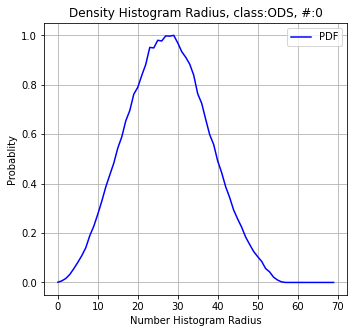

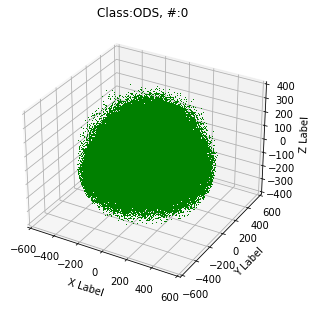

In [24]:
visualize  = True
class_name = 'ODS'
number_rad = 70
colors     = ['g','b','k','y','m','c']
index_radius_ODS,hist_radius_mod_ODS = Operations.compare_histogram_radius(normalized_dataset_dict['ODS'], all_hist_radius_ODS, number_rad = number_rad,  class_name = class_name,confidence = 0.99, colors = colors, visualize=visualize)

## Get Features for FOCTS

In [25]:
number_bin = 45
all_hist_angle_FOCTS = Operations.histogram_angle(normalized_dataset_dict['FOCTS'],number_bin)

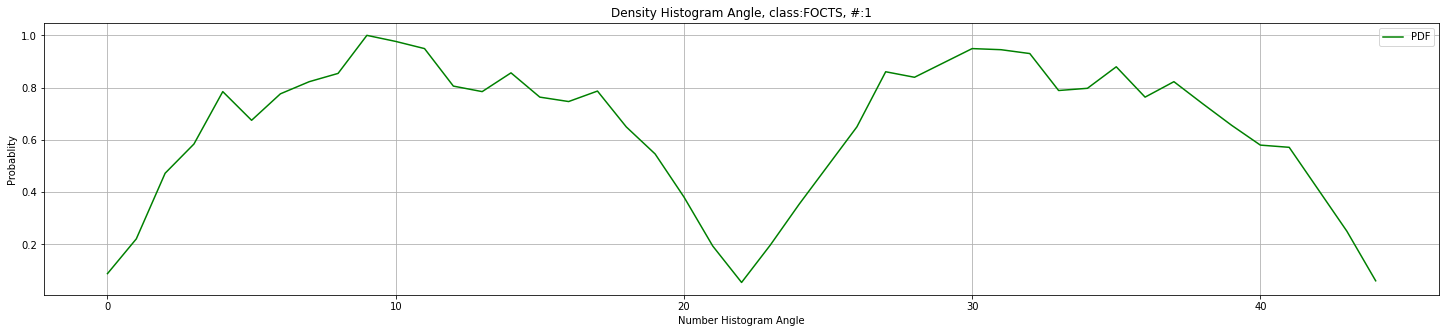

In [26]:
sample_per_class = 4
class_name       = 'FOCTS'
colors           = ['g','b','k','y','m','c']
number_bin       = 45
Operations.draw_histogram_angle(all_hist_angle_FOCTS, number_bin = number_bin, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

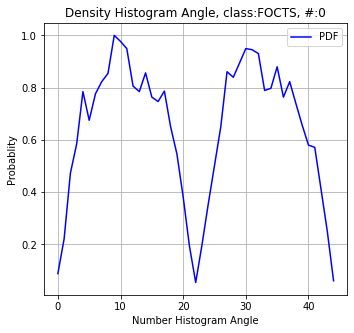

0


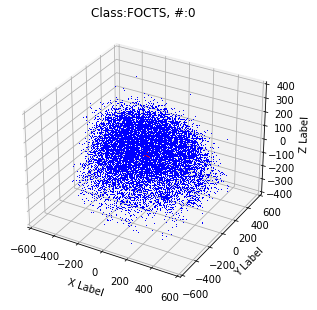

In [27]:
number_bin = 45
class_name = 'FOCTS'
visualize  = True
index_angle_FOCTS, hist_angle_mod_FOCTS = Operations.compare_histogram_angle(normalized_dataset_dict['FOCTS'], all_hist_angle_FOCTS, class_name = class_name, number_bin = number_bin, visualize = visualize)

In [28]:
distance_bet_radius   = 10
number_rad            = 70
all_hist_radius_FOCTS = Operations.histogram_radius(normalized_dataset_dict['FOCTS'], number_rad = number_rad, distance_bet_radius = distance_bet_radius)

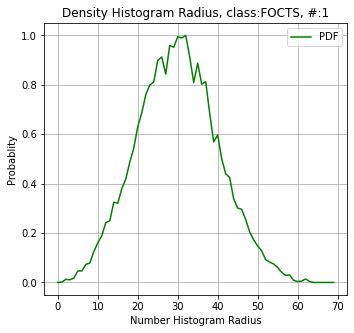

In [29]:
sample_per_class = 4
class_name       = 'FOCTS'
number_rad       = 70
colors           = ['g','b','k','y','m','c']
Operations.draw_histogram_radius(all_hist_radius_FOCTS, number_rad = number_rad, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

mod is :  0  Value is  0.9999999999999999


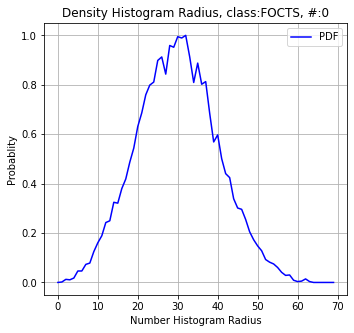

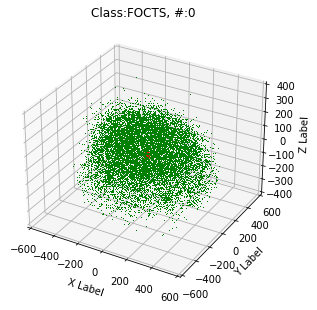

In [30]:
visualize  = True
class_name = 'FOCTS'
number_rad = 70
colors     = ['g','b','k','y','m','c']
index_radius_FOCTS, hist_radius_mod_FOCTS = Operations.compare_histogram_radius(normalized_dataset_dict['FOCTS'], all_hist_radius_FOCTS, number_rad = number_rad,  class_name = class_name, confidence = 0.99, colors = colors, visualize=visualize)

## Get Features for PEG

In [31]:
number_bin = 45
all_hist_angle_PEG = Operations.histogram_angle(normalized_dataset_dict['PEG'],number_bin)

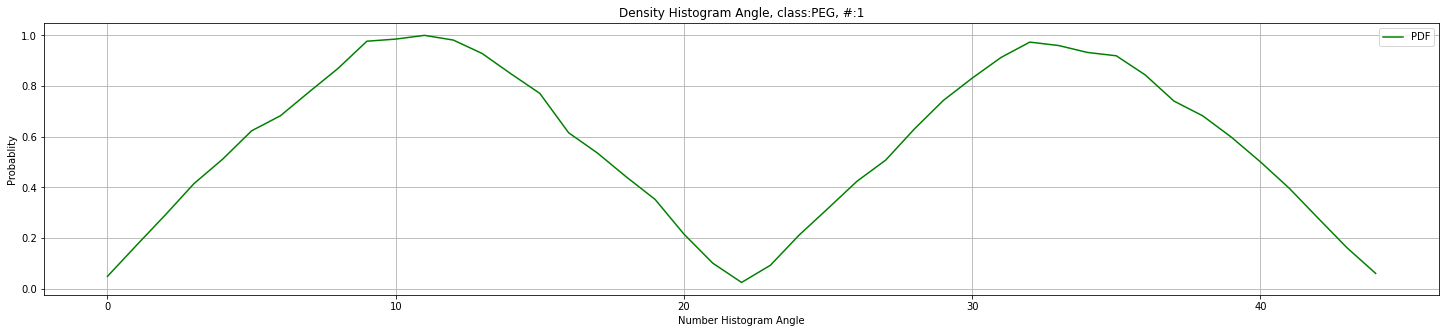

In [32]:
sample_per_class = 4
class_name       = 'PEG'
colors           = ['g','b','k','y','m','c']
Operations.draw_histogram_angle(all_hist_angle_PEG, number_bin = number_bin, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

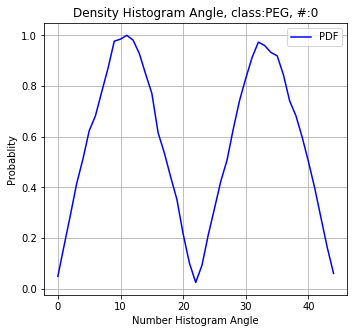

0


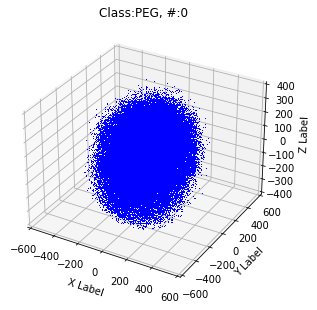

In [33]:
number_bin = 45
class_name = 'PEG'
visualize  = True
index_angle_PEG, hist_angle_mod_PEG = Operations.compare_histogram_angle(normalized_dataset_dict['PEG'], all_hist_angle_PEG, class_name = class_name, number_bin = number_bin, visualize = visualize)

In [34]:
distance_bet_radius   = 10
number_rad            = 70
all_hist_radius_PEG = Operations.histogram_radius(normalized_dataset_dict['PEG'], number_rad = number_rad, distance_bet_radius = distance_bet_radius)

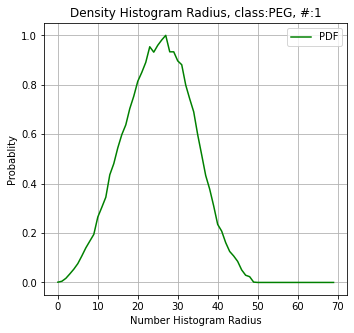

In [35]:
sample_per_class = 4
class_name       = 'PEG'
number_rad       = 70
colors           = ['g','b','k','y','m','c']
Operations.draw_histogram_radius(all_hist_radius_PEG, number_rad = number_rad, sample_per_class = sample_per_class, class_name = class_name, colors = colors)

mod is :  0  Value is  1.0


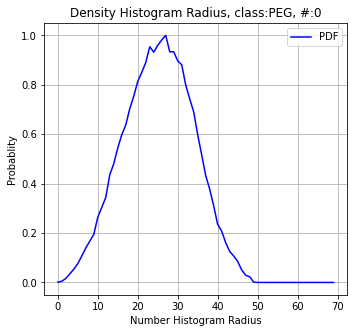

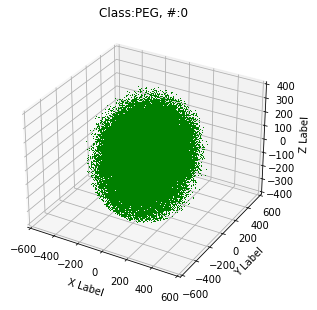

In [36]:
visualize  = True
class_name = 'PEG'
number_rad = 70
colors     = ['g','b','k','y','m','c']
index_radius_PEG, hist_radius_mod_PEG = Operations.compare_histogram_radius(normalized_dataset_dict['PEG'], all_hist_radius_PEG, number_rad = number_rad,  class_name = class_name, confidence = 0.99, colors = colors, visualize=visualize)

## Show 3 Selected Sample Point_Clouds

In [37]:
Selected_Points = []
# Selected_Points.append(dataset_dictionary['GLAS'][index_radius_GLAS])
Selected_Points.append(dataset_dictionary['FOCTS'][index_radius_FOCTS])
Selected_Points.append(dataset_dictionary['PEG'][index_radius_PEG])
Selected_Points.append(dataset_dictionary['ODS'][index_radius_ODS])

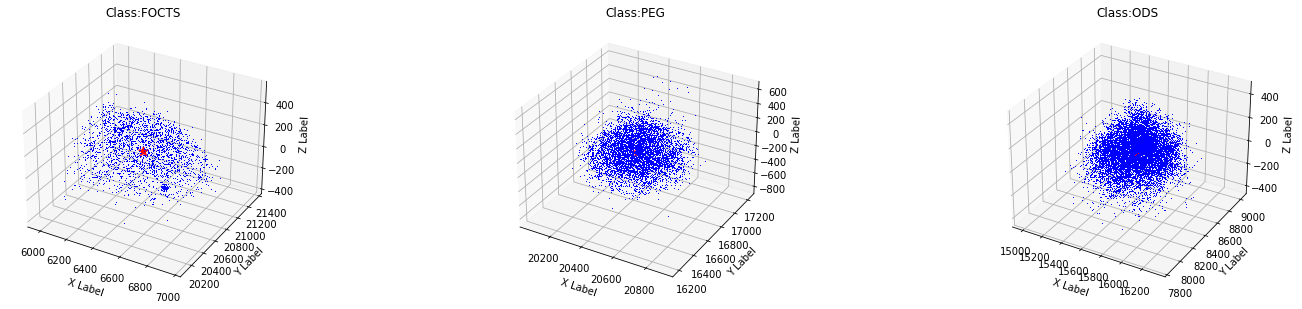

In [38]:
sample_per_class = 3
colors           = ['g','b','k','y','m','c']
set_axis_limit   = False
my_utils.depict_best_3D(Selected_Points, sample_per_class = sample_per_class, colors = colors, set_axis_limit   = set_axis_limit)

/home/staff/azad/deeplearning/pointcloud/July_newb/src/real_data/utils/my_utils.py:122: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(1, 1, 1)
/home/staff/azad/deeplearning/pointcloud/July_newb/src/real_data/utils/my_utils.py:122: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(1, 1, 1)


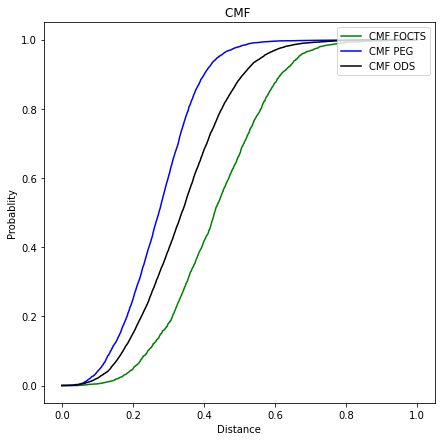

In [39]:
surfaces = ['FOCTS','PEG','ODS']
group_cmf = my_utils.depict_cmf_group(Selected_Points, surfaces, sample_per_class = sample_per_class)

In [40]:
Selected_Points_Centralized = []
# Selected_Points_Centralized.append(processed_points_GLAS[index_radius_GLAS])
Selected_Points_Centralized.append(normalized_dataset_dict['FOCTS'][index_radius_FOCTS])
Selected_Points_Centralized.append(normalized_dataset_dict['PEG'][index_radius_PEG])
Selected_Points_Centralized.append(normalized_dataset_dict['ODS'][index_radius_ODS])

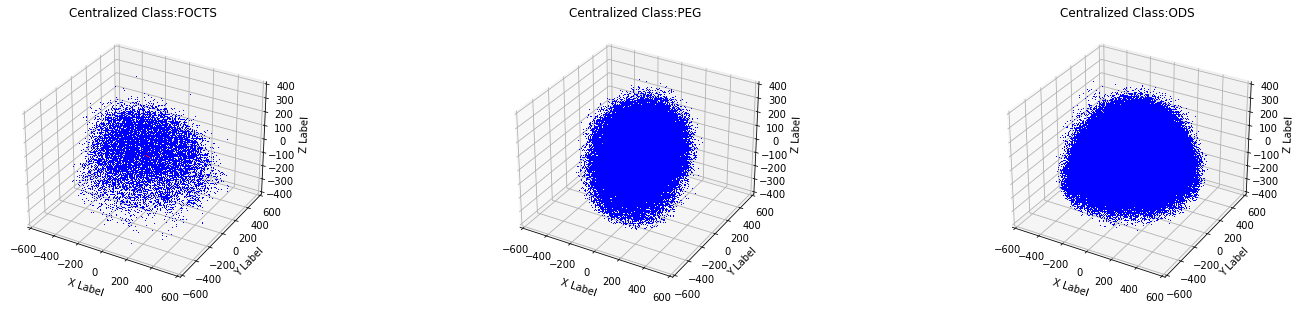

In [41]:
sample_per_class = 3
colors           = ['g','b','k','y','m','c']
set_axis_limit   = True
my_utils.depict_best_3D(Selected_Points_Centralized, sample_per_class = sample_per_class, colors = colors, set_axis_limit   = set_axis_limit)

## Map 3d point clouds to 2d: display map for different planes

/home/staff/azad/deeplearning/pointcloud/July_newb/src/real_data/utils/my_utils.py:378: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(1, 3, idx+1)


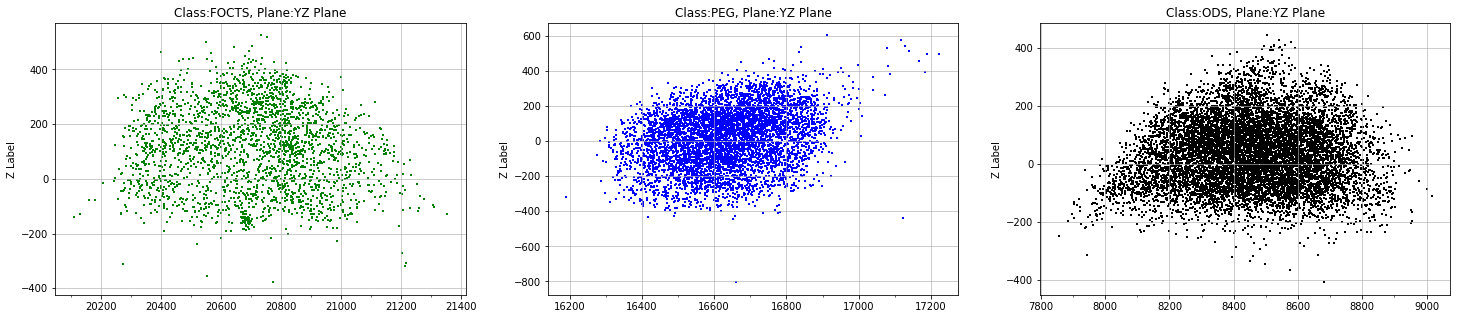

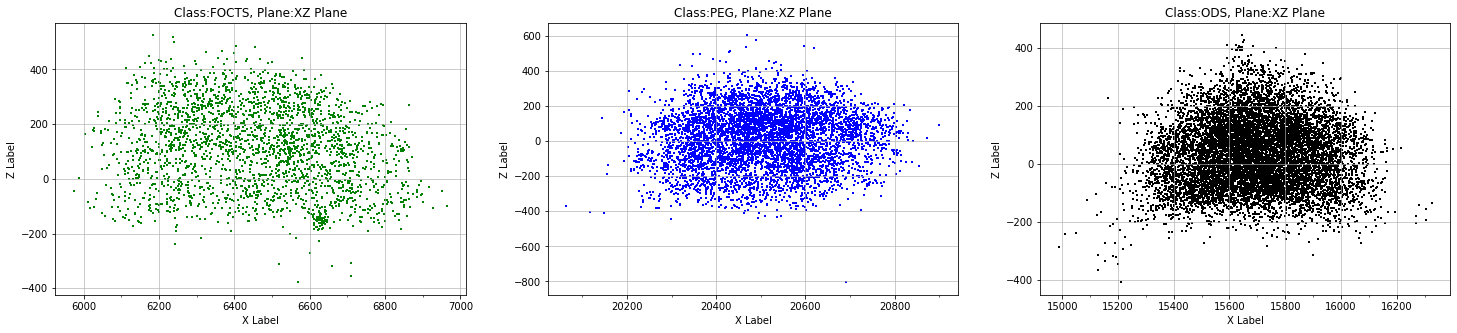

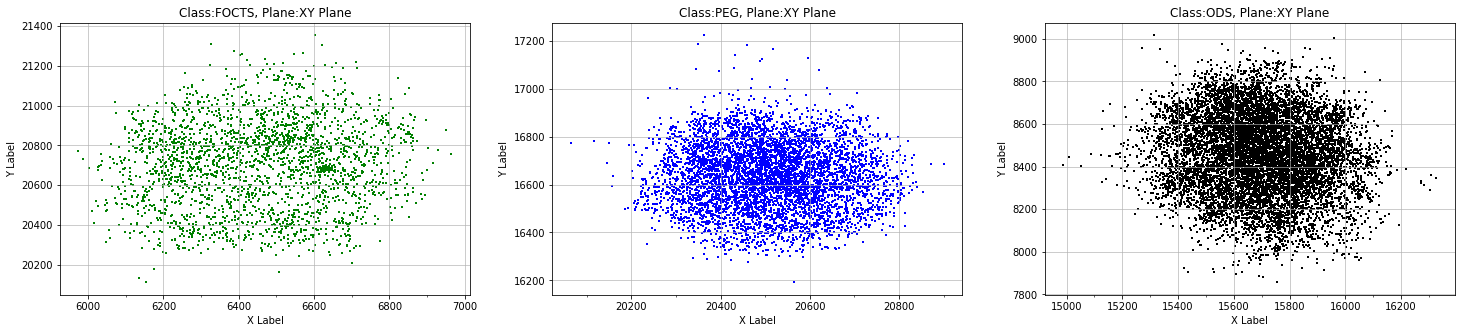

In [42]:
surface          = ['FOCTS', 'PEG', 'ODS']
Centralized      = False
sample_per_class = 3
colors           = ['g','b','k','y','m','c']
set_axis_limit   = False
my_utils.depict_map_2D(Selected_Points, surface, sample_per_class = sample_per_class, colors = colors, set_axis_limit = set_axis_limit, Centralized = Centralized)

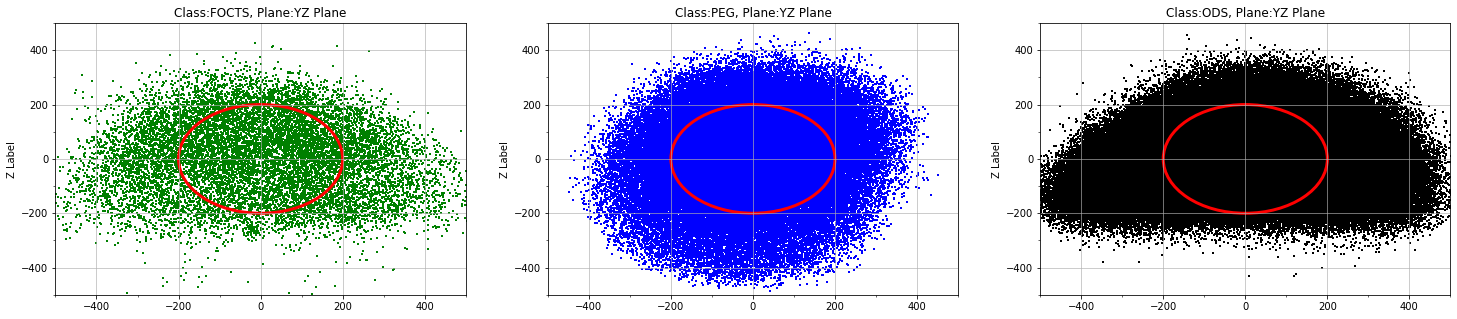

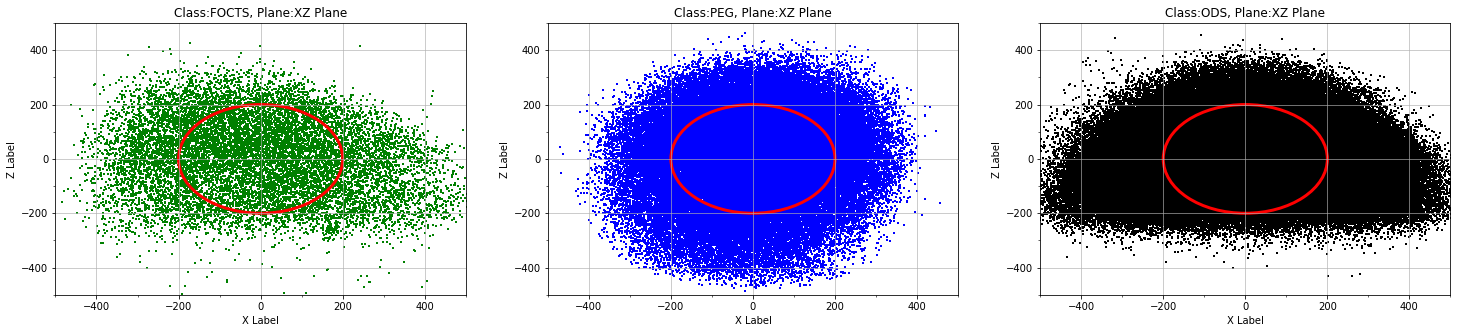

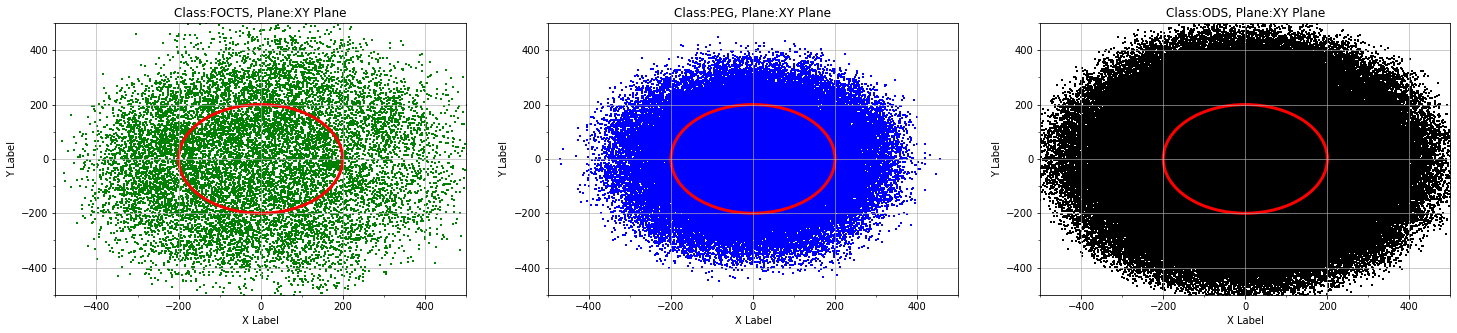

In [43]:
surface          = ['FOCTS', 'PEG', 'ODS']
Centralized      = True
sample_per_class = 3
colors           = ['g','b','k','y','m','c']
set_axis_limit   = False
my_utils.depict_map_2D(Selected_Points_Centralized, surface, sample_per_class = sample_per_class, colors = colors, set_axis_limit = set_axis_limit, Centralized = Centralized)

## Histogram of data based on angles in different planes

In [44]:
radius      = 200
number_bin  = 45
hist_angle_FOCTS_map_2D  = Operations.hist_angle_map(Selected_Points_Centralized[0], number_bin, radius)
hist_angle_PEG_map_2D    = Operations.hist_angle_map(Selected_Points_Centralized[1], number_bin, radius)
hist_angle_ODS_map_2D    = Operations.hist_angle_map(Selected_Points_Centralized[2], number_bin, radius)
hist_map_2d = []
for i in range(3):
    hist_map_2d.append(hist_angle_FOCTS_map_2D[i])
    hist_map_2d.append(hist_angle_PEG_map_2D[i])
    hist_map_2d.append(hist_angle_ODS_map_2D[i])

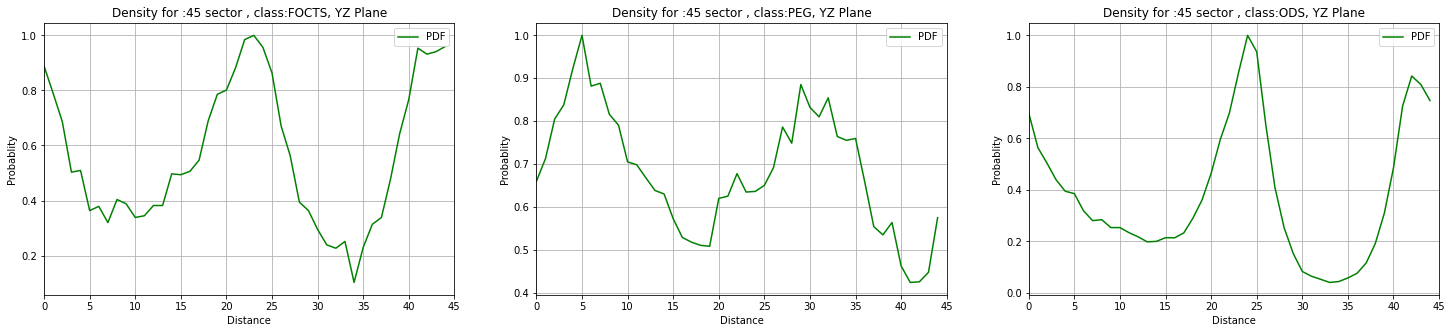

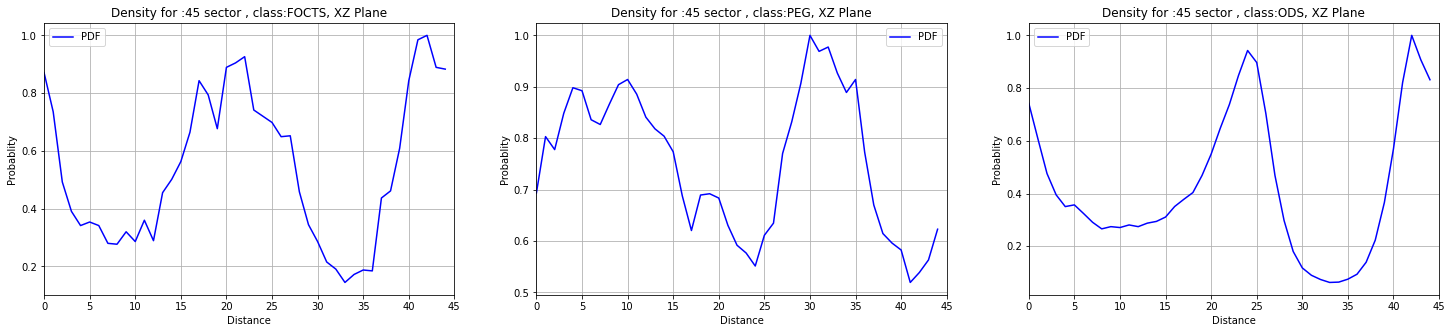

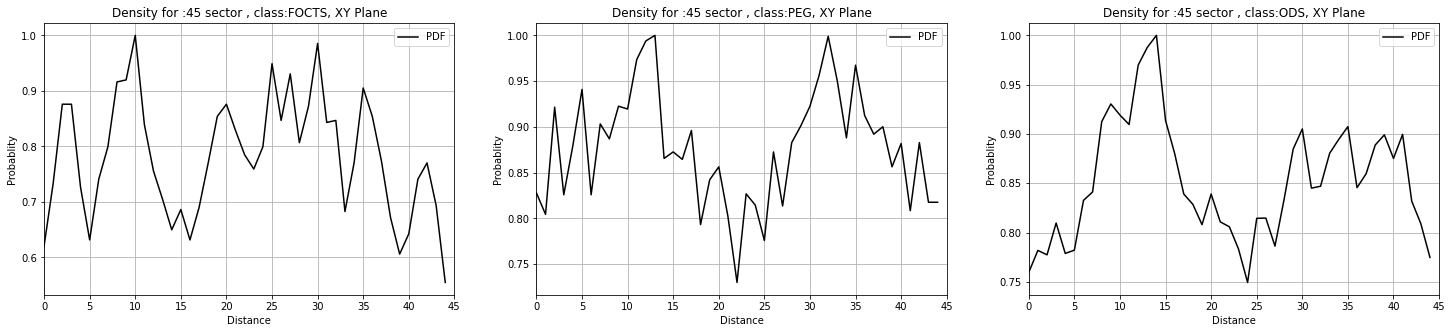

In [45]:
surface     = ['FOCTS', 'PEG', 'ODS']
number_bin  = 45
my_utils.draw_hist_angle_map_2d(hist_map_2d, surface, number_bin)

In [46]:
radius           = 200
number_bin       = 45
average_distance = True
#
hist_angle_FOCTS_map_2D, max_dist_FOCTS, mean_dist_FOCTS, which_point_FOCTS = Operations.hist_angle_map_new(Selected_Points_Centralized[0], number_bin = number_bin, radius = radius, )
hist_angle_PEG_map_2D, max_dist_PEG, mean_dist_PEG, which_point_PEG         = Operations.hist_angle_map_new(Selected_Points_Centralized[1], number_bin = number_bin, radius = radius, )
hist_angle_ODS_map_2D, max_dist_ODS, mean_dist_ODS, which_point_ODS         = Operations.hist_angle_map_new(Selected_Points_Centralized[2], number_bin = number_bin, radius = radius, )

ratio_FOCTS = np.array(mean_dist_FOCTS)/np.array(max_dist_FOCTS)
ratio_FOCTS = np.nan_to_num(ratio_FOCTS, nan=0)
ratio_PEG = np.array(mean_dist_PEG)/np.array(max_dist_PEG)
ratio_PEG = np.nan_to_num(ratio_PEG, nan=0)
ratio_ODS = np.array(mean_dist_ODS)/np.array(max_dist_ODS)
ratio_ODS = np.nan_to_num(ratio_ODS, nan=0)

ratio_list= []
for i in range(3):
    ratio_list.append(ratio_FOCTS[i])
    ratio_list.append(ratio_PEG[i])
    ratio_list.append(ratio_ODS[i])
    
hist_map_2d_density = []
for i in range(3):
    hist_map_2d_density.append(hist_angle_FOCTS_map_2D[i])
    hist_map_2d_density.append(hist_angle_PEG_map_2D[i])
    hist_map_2d_density.append(hist_angle_ODS_map_2D[i])
hist_map_2d_distance = []
if average_distance:
    for i in range(3):
        hist_map_2d_distance.append(mean_dist_FOCTS[i])
        hist_map_2d_distance.append(mean_dist_PEG[i])
        hist_map_2d_distance.append(mean_dist_ODS[i])
else:
    for i in range(3):
        hist_map_2d_distance.append(max_dist_FOCTS[i])
        hist_map_2d_distance.append(max_dist_PEG[i])
        hist_map_2d_distance.append(max_dist_ODS[i])
Max_Point_Sector = []
for i in range(3):
    Max_Point_Sector.append(which_point_FOCTS[i])
    Max_Point_Sector.append(which_point_PEG[i])
    Max_Point_Sector.append(which_point_ODS[i])

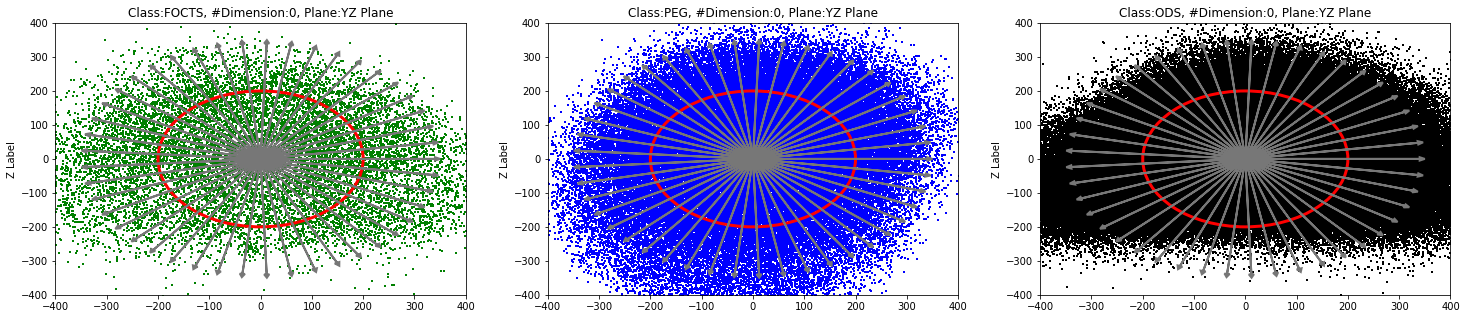

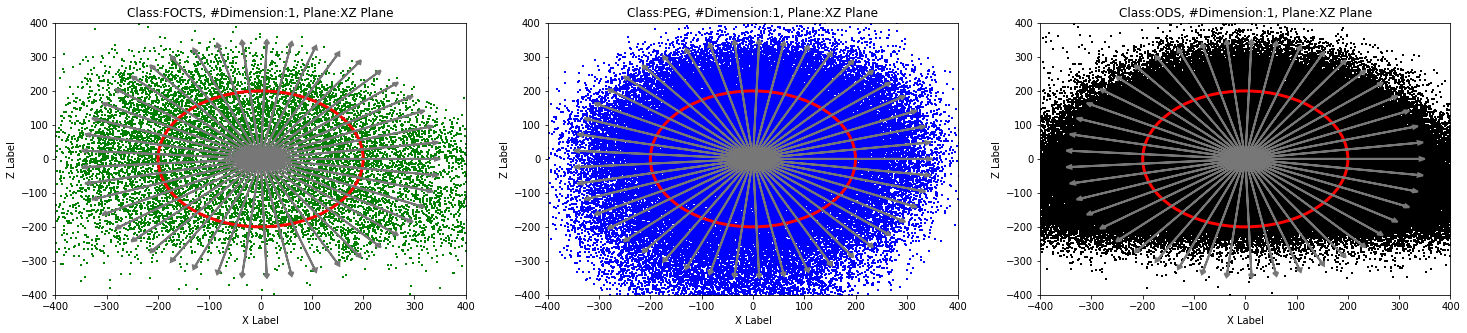

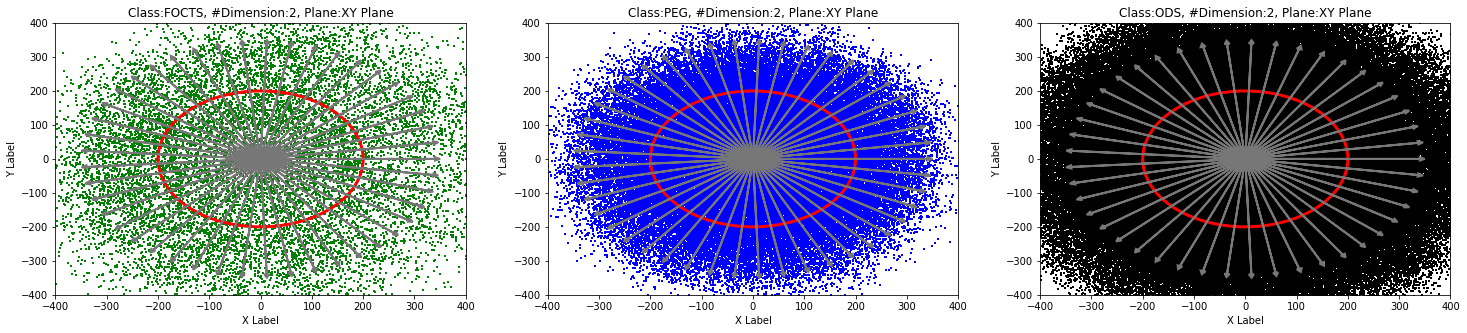

In [47]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
number_bin  = 45
my_utils.depict_pointcloud_2D(Selected_Points_Centralized, surface, Max_Point_Sector, Centralized, number_bin)

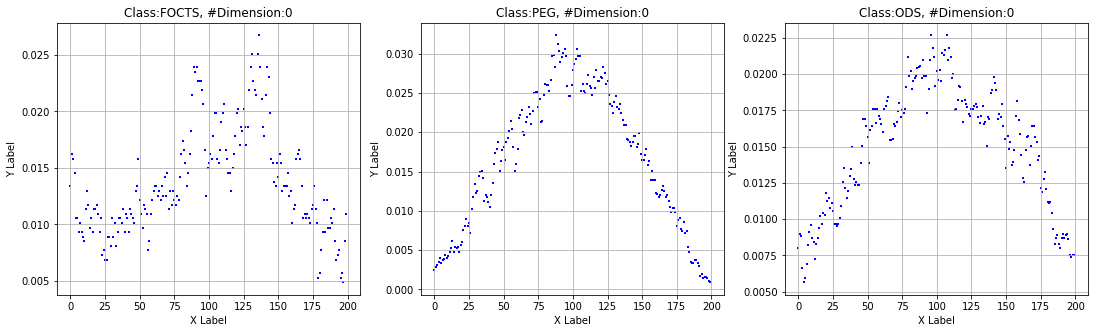

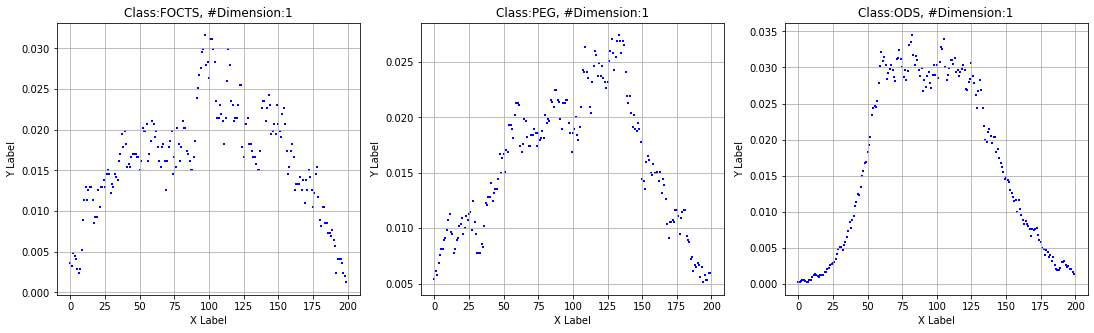

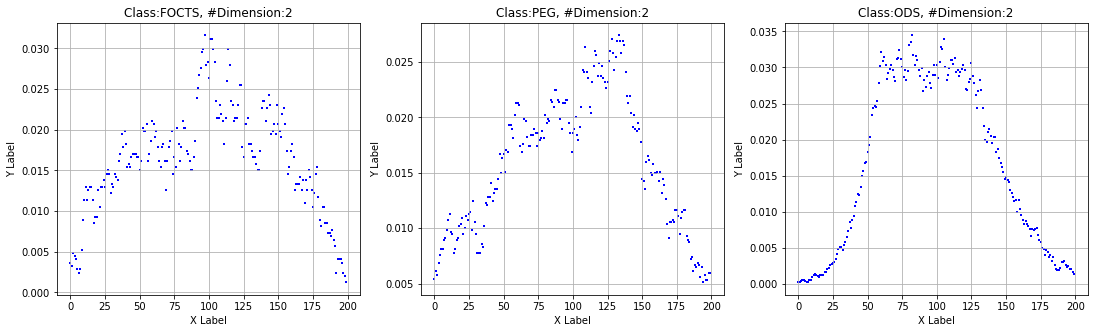

In [48]:
surface     = ['FOCTS', 'PEG', 'ODS']
radius      = 200
colors      = ['g', 'b', 'k','y','m','c']
my_utils.draw_histogram_pointcloud_plane(Selected_Points, surface, radius = radius, colors = colors)

/home/staff/azad/deeplearning/pointcloud/July_newb/src/real_data/utils/Operations.py:502: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1          = fig.add_subplot(1, len(surface), idx+1)


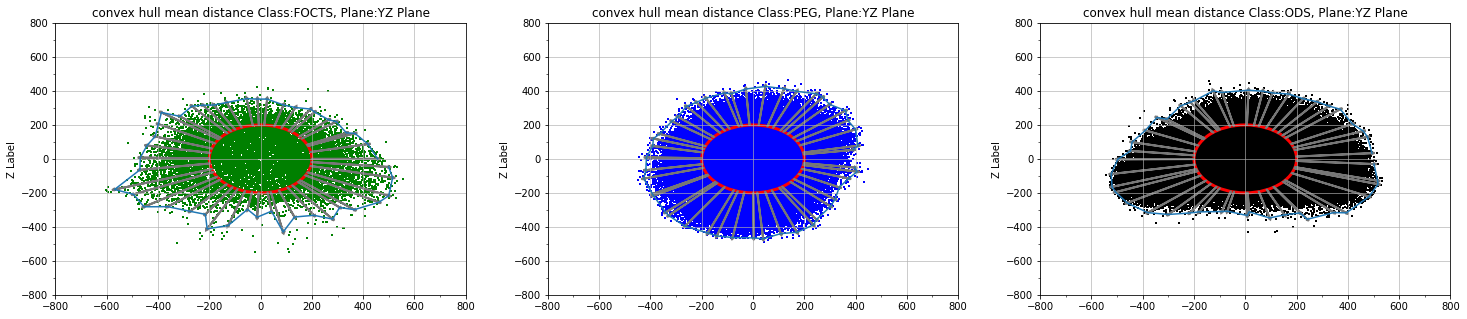

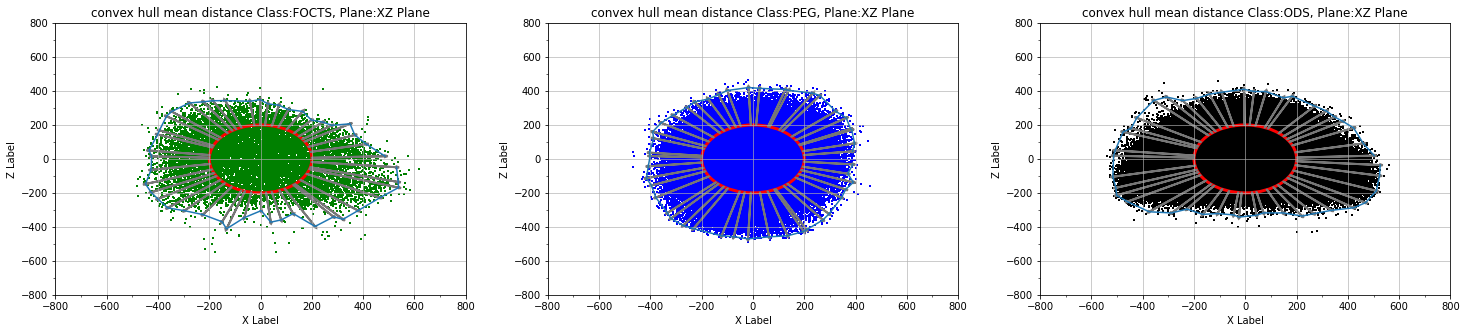

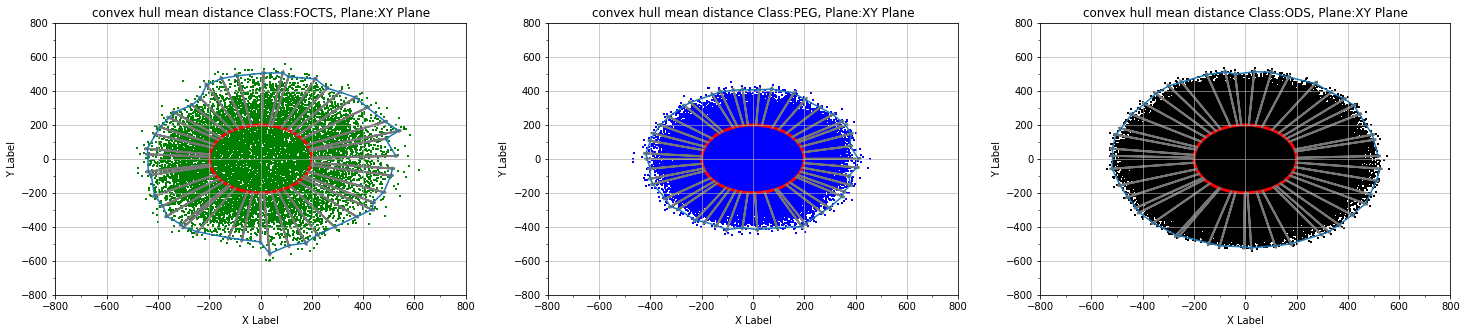

In [49]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = True
Operations.convex_hull_2D(Selected_Points_Centralized, surface, ratio_list, hist_map_2d_distance, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

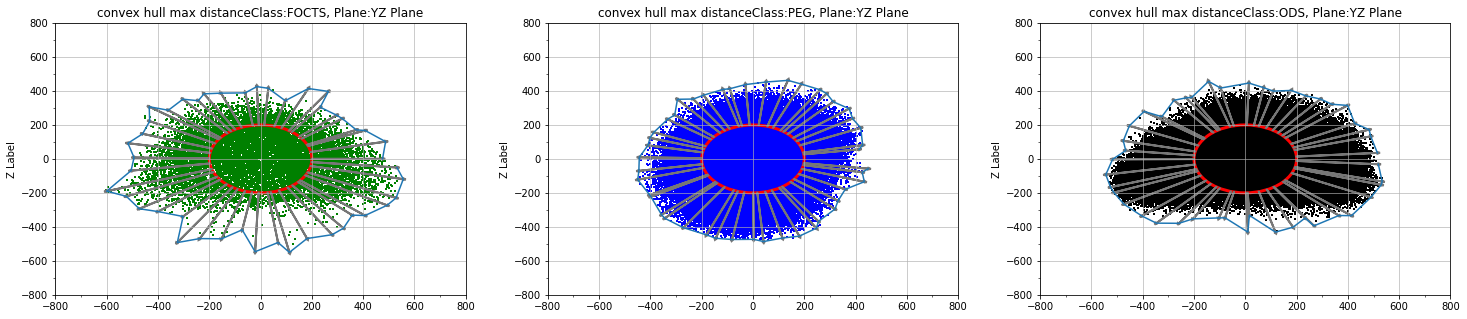

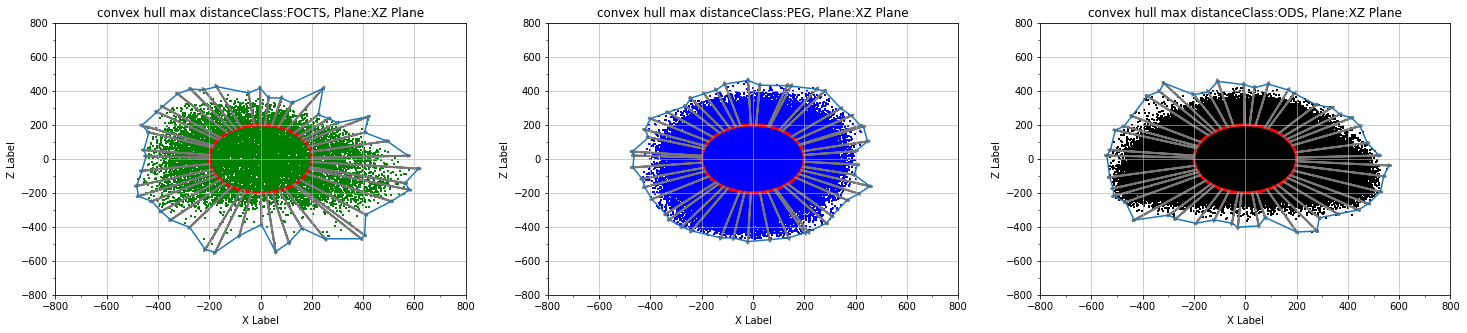

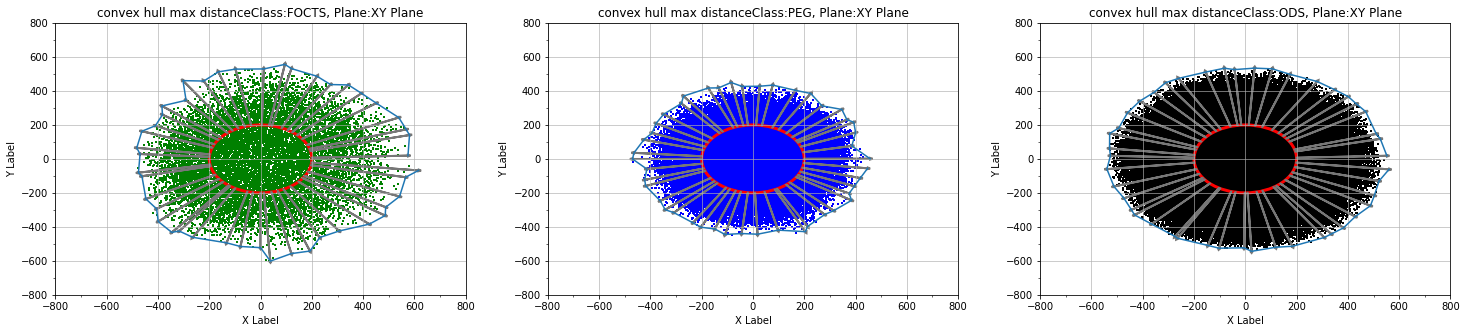

In [50]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = False
Operations.convex_hull_2D(Selected_Points_Centralized, surface, ratio_list, hist_map_2d_distance, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

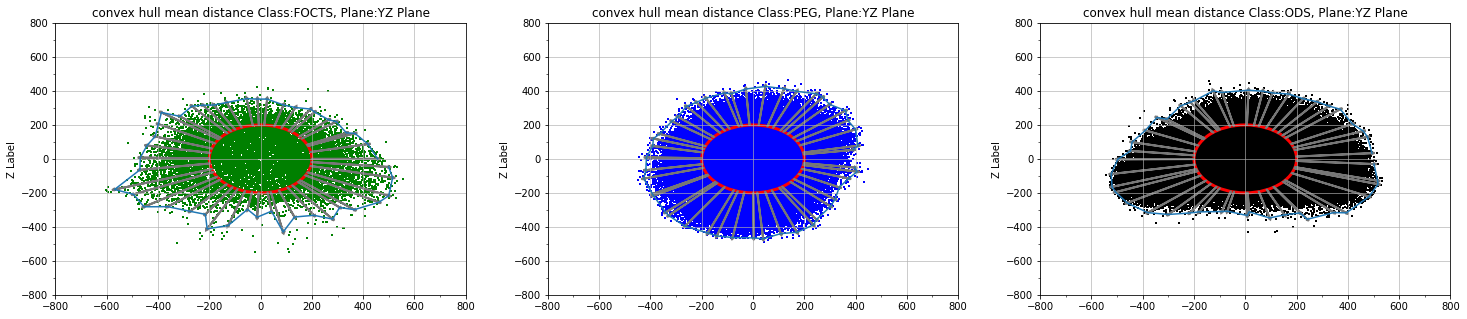

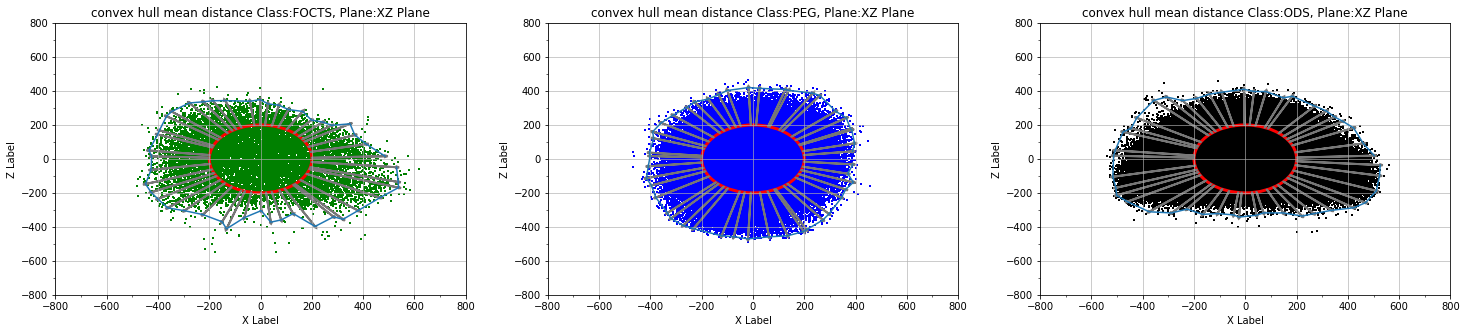

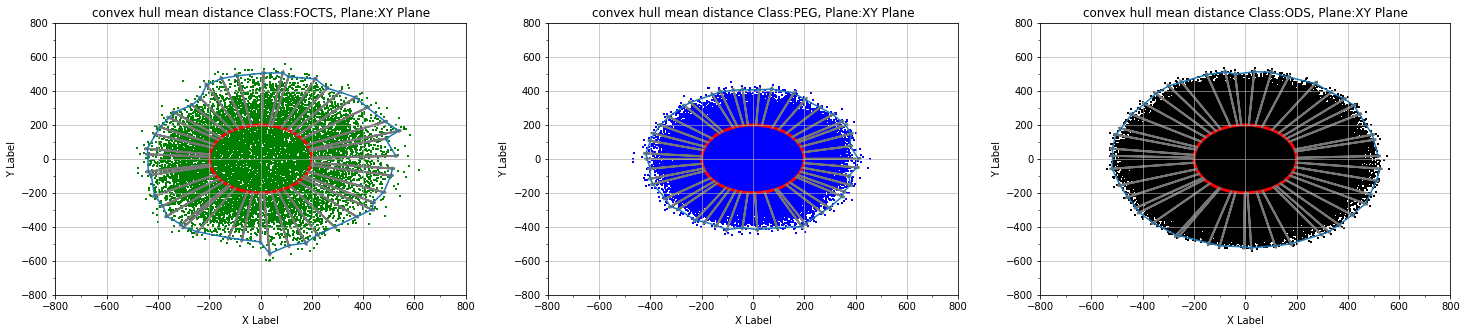

In [51]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = True
Operations.convex_hull_2D(Selected_Points_Centralized, surface, ratio_list, hist_map_2d_distance, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

/home/staff/azad/deeplearning/pointcloud/July_newb/src/real_data/utils/Operations.py:626: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1          = fig.add_subplot(1, len(surface), idx+1)


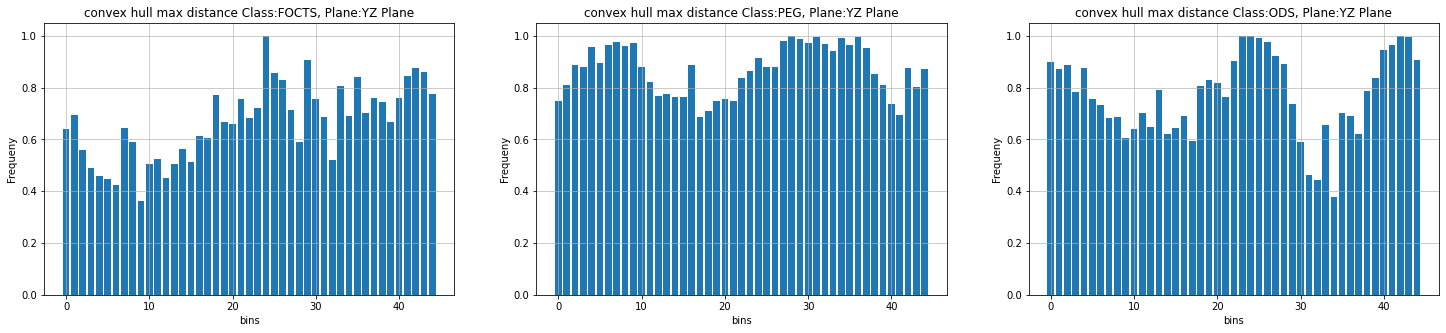

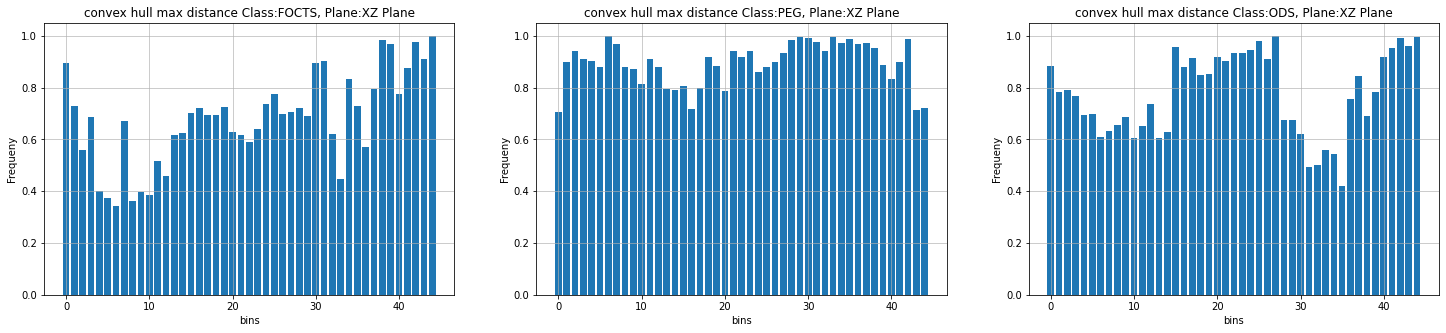

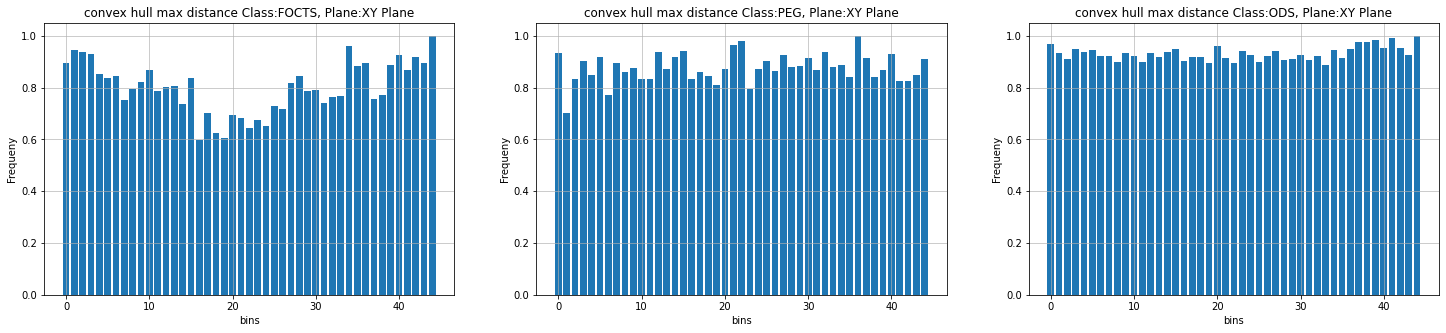

In [52]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = False
Operations.histogram_convex_hull_2D(Selected_Points_Centralized, surface, ratio_list, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

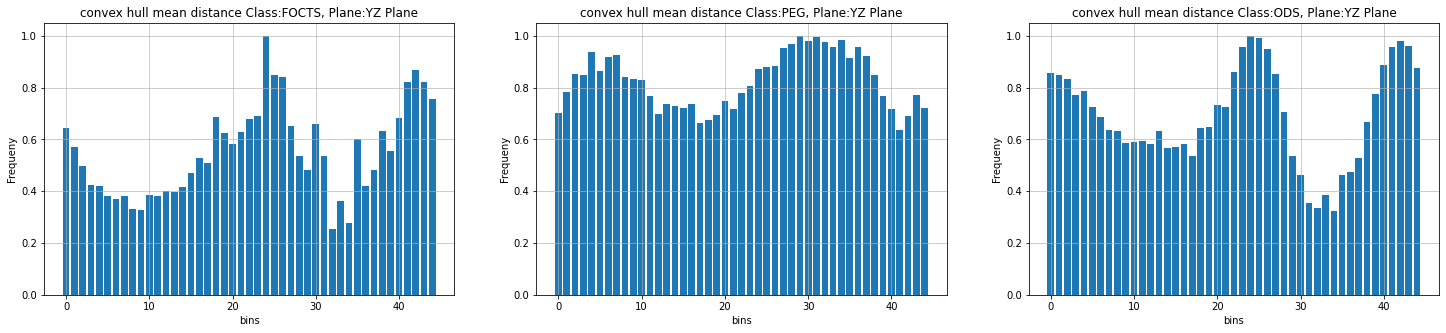

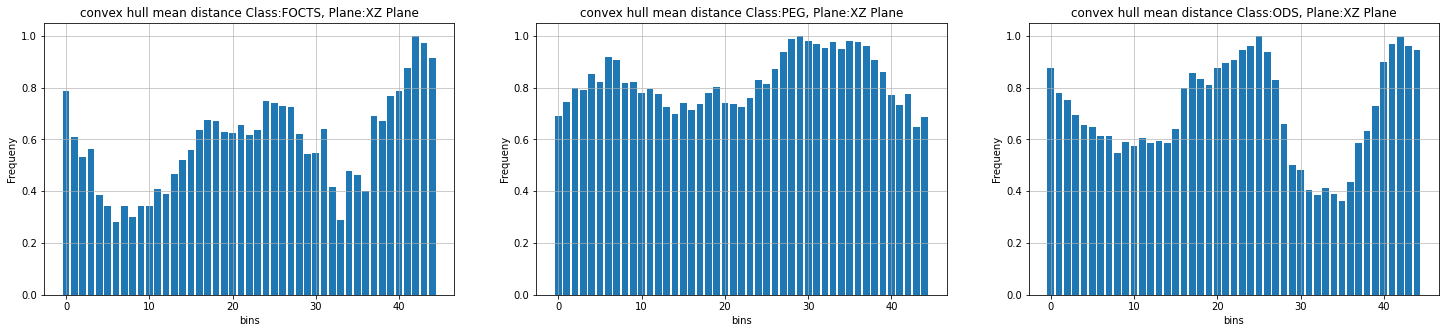

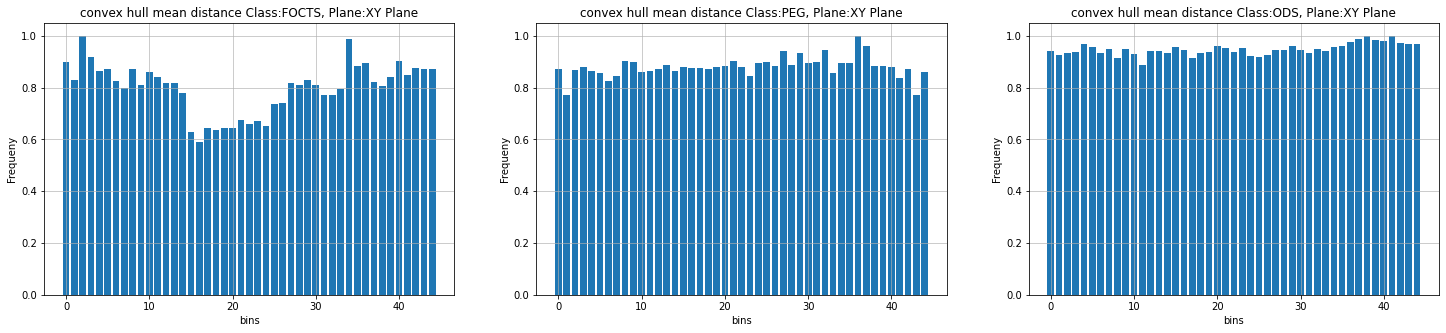

In [53]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = True
Operations.histogram_convex_hull_2D(Selected_Points_Centralized, surface, ratio_list, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

In [54]:
surface     = ['FOCTS', 'PEG', 'ODS']
Centralized = True
colors      = ['g', 'b', 'k','y','m','c']
radius      = 200
number_bin  = 45
mean_dist   = True
all_pose_convex_hull = Operations.get_convex_hull_pose(Selected_Points_Centralized, surface, ratio_list, Max_Point_Sector, Centralized, number_bin, colors = colors, radius = radius, mean_dist = mean_dist)

## Moment

#### The geometric moments are most widely used in image analysis and pattern recognition tasks. This is due essentially to their simplicity, the invariance and geometric meaning of the low order moment values. In fact, the zeroth order moment, M00, represents the total mass of the image. The two first order moments, (M10, M01), provide the position of the center of mass. The second order moments, (M20, M11, M02), can be used to determine several useful image features such as the principal axes, the image ellipse and the radii of gyration

### zernike moment is invariant respect to orientation and variant respect to transition and scaling.

#### It's better to normalize size of all convex hull: scaling them to specific size using bounding box

### Hu Moment: from central moments: are invariant respect to scaling, orientation and transition

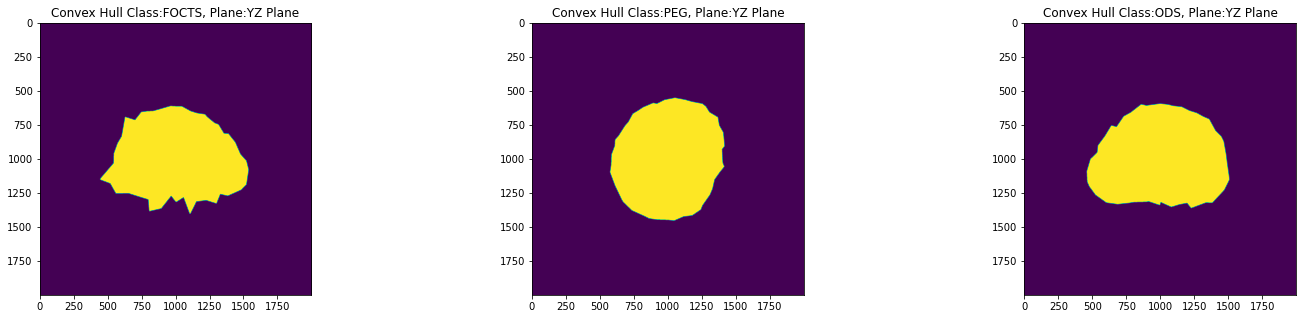

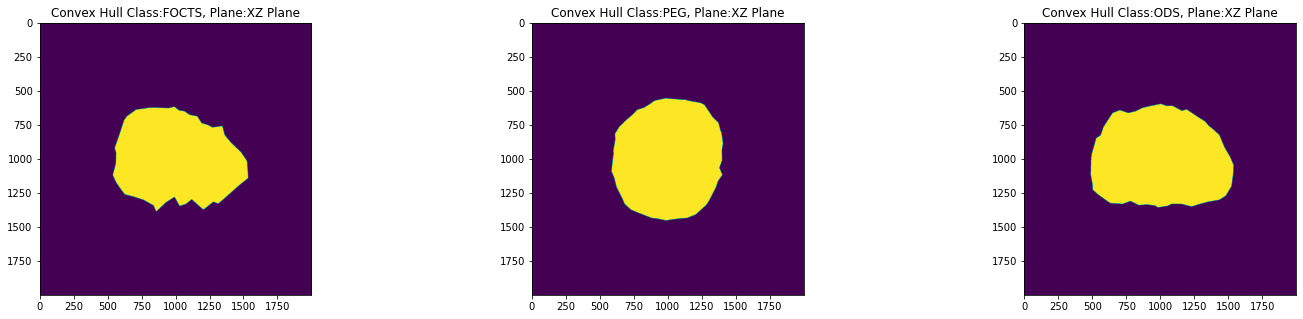

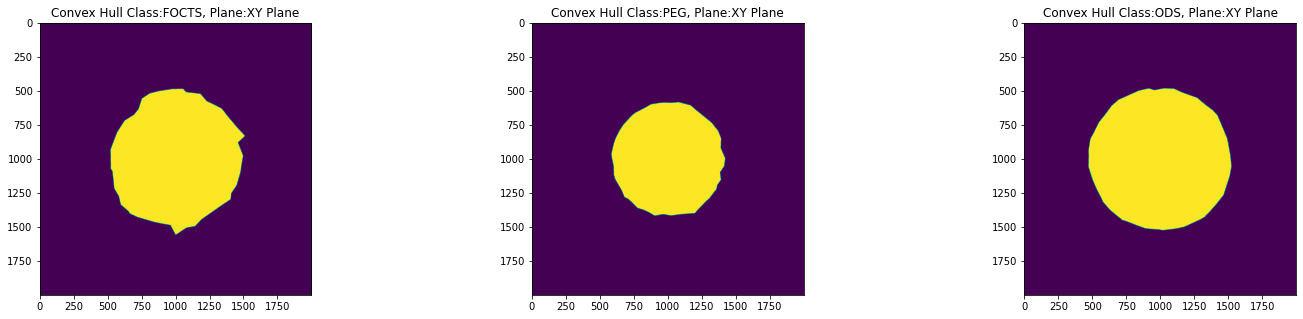

In [55]:
surface     = ['FOCTS', 'PEG', 'ODS']
planes      = ['YZ Plane','XZ Plane','XY Plane']
radius      = 10
degree      = 8
resizeing   = False
# Operations.
Hu_dataframes, zernike_dataframes, list_image_convex_hull, list_contours = Moments.display_convex_image(all_pose_convex_hull, surface = surface, planes = planes, radius = radius, degree = degree, resizeing = resizeing)

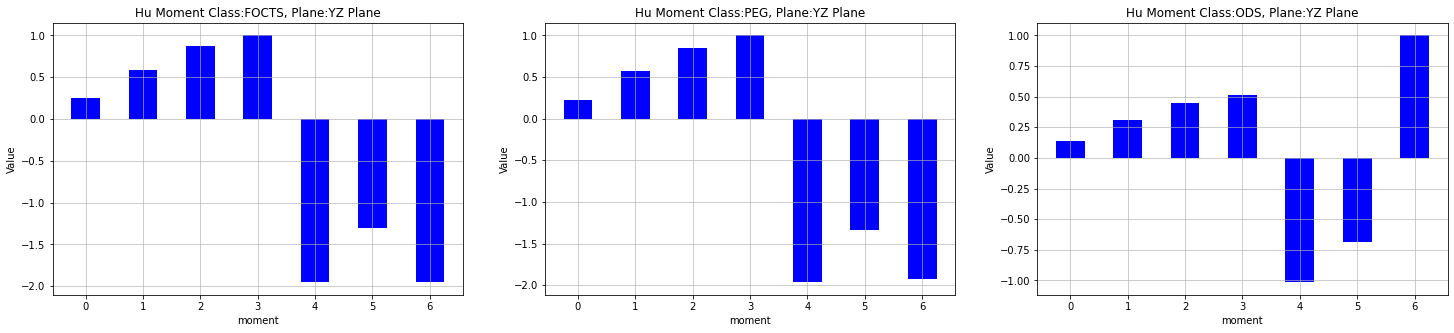

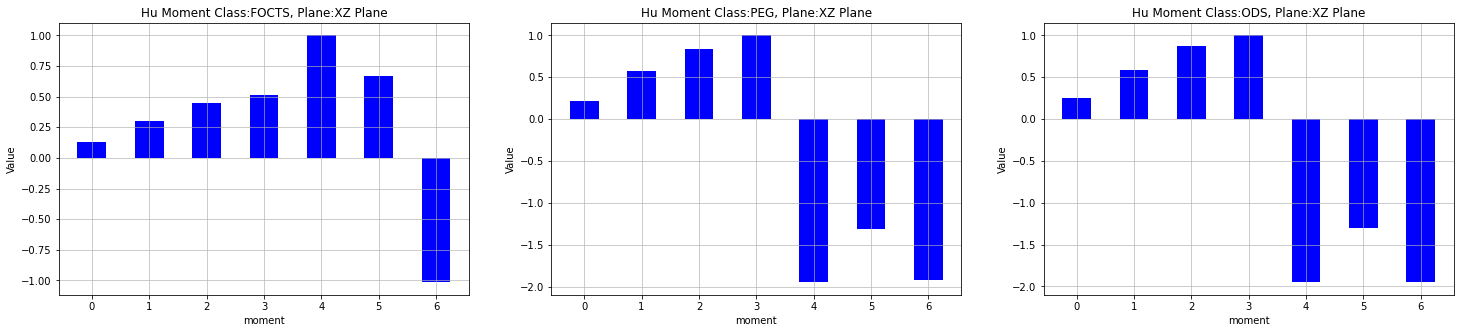

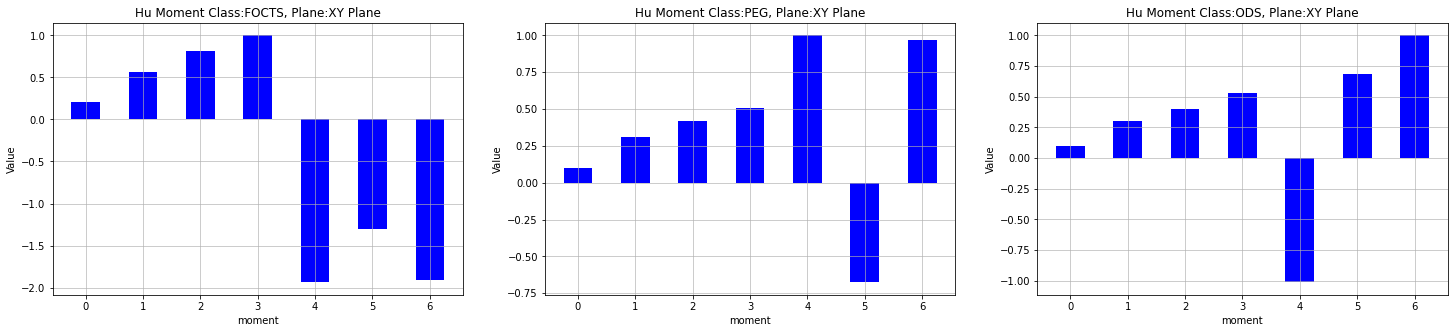

In [56]:
surface     = ['FOCTS', 'PEG', 'ODS']
colors      = ['g', 'b', 'k','y','m','c']
Moments.histogram_moment(Hu_dataframes, surface, colors, hu_moment = True )

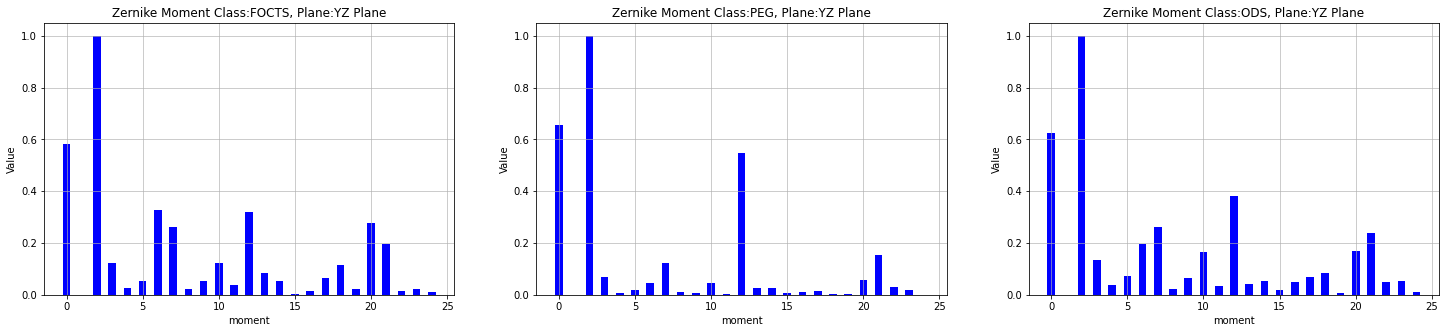

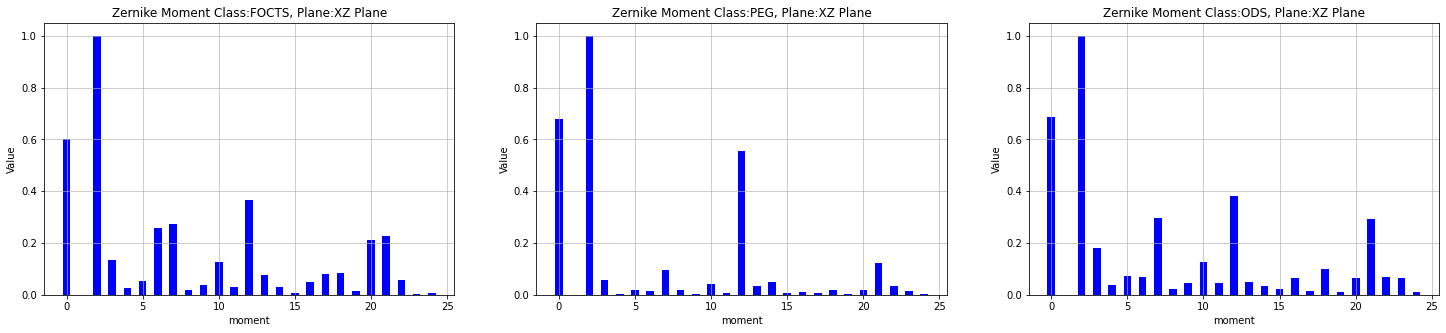

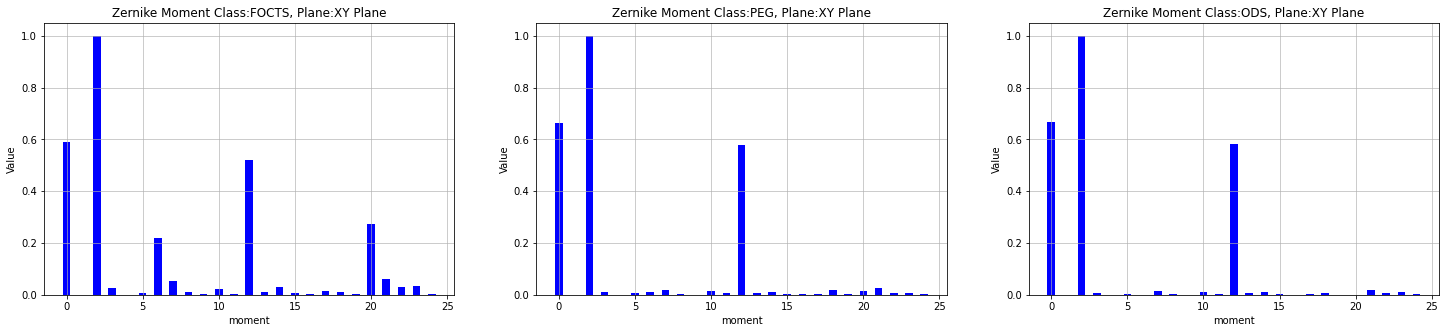

In [57]:
surface     = ['FOCTS', 'PEG', 'ODS']
colors      = ['g', 'b', 'k','y','m','c']
Moments.histogram_moment(zernike_dataframes, surface, colors, hu_moment = False )

## Contours Distance

In [58]:
surface     = ['FOCTS', 'PEG', 'ODS']
colors      = ['g', 'b', 'k','y','m','c']
Moments.contour_distance(list_image_convex_hull, surface)

plane YZ Plane distance FOCTS and PEG is 0.009907211129112654
plane YZ Plane distance FOCTS and ODS is 0.0014271949250725892
plane YZ Plane distance PEG and ODS is 0.00839682706548763
plane XZ Plane distance FOCTS and PEG is 0.009335576743755727
plane XZ Plane distance FOCTS and ODS is 0.00012609854313450075
plane XZ Plane distance PEG and ODS is 0.009124297619957249
plane XY Plane distance FOCTS and PEG is 0.0006262551381844137
plane XY Plane distance FOCTS and ODS is 0.0007104116488291627
plane XY Plane distance PEG and ODS is 8.410384018269351e-05


activate jupyter notebook themes

## Generate Statistcs for test sample

In [59]:
# !jt -t onedork -T -N -kl

In [60]:
number_bin = 45
all_hist_angle_TEST = Operations.histogram_angle([point_cloud],number_bin)

NameError: name 'point_cloud' is not defined

## Generate Sample Gaussian Distribution

In [ ]:
number_bin = 45
class_name = 'Test'
visualize  = True
index_angle_TEST,hist_angle_mod_TEST = Operations.compare_histogram_angle([point_cloud], all_hist_angle_test, class_name = class_name, number_bin = number_bin, visualize = visualize)

In [ ]:
sigma_x = 0.5
sigma_y = 0.5
point_cloud = generate_point_cloud.generate_gaussian(sigma_x, sigma_y)
rgb_points = None
filename   = "D:\point_cloud.ply"
generate_point_cloud.write_pointcloud(filename, point_cloud, rgb_points)

In [ ]:
import numpy as np 

n = 5000
r = 100

generateRandom = True
generateFixed = True

if (generateRandom):
    print("Generating randomly %d points on a sphere centered at the origin" % (n))
    theta = np.random.uniform(0.0,2*np.pi,n)
    z = np.random.uniform(-1.0,1.0,n)
    xp, zpa, yp = [],[], []
    for i in range (0,n):
        zpa.append(z[i])
        zp = z[i]
        xp.append(np.sqrt(r*r - zp*zp)* np.cos(theta[i]))
        yp.append(np.sqrt(r*r - zp*zp)* np.sin(theta[i]))
xp = np.array(xp)*r   
yp = np.array(yp)*r
zp = np.array(zp)*r

fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(1, 1,1, projection="3d")
ax1.scatter(xp, yp, zp, s=1, c='red', marker="s", facecolor="red", lw=0, alpha=1)
            


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_spherical(100)
fig = plt.figure(figsize=(25,25))
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'auto'})
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)

In [ ]:
xp.shape

In [ ]:
def depict_normalzed_cmf_sample(point_cloud, colors = ['m', 'c']):
    """
    This function receives a point clouds draws  normalized cumulative distribution function (CDF)
    point clouds(between 0 and 100).    
    
     Args:
         point_cloud: a point clouds
         colors: list of 2 colors
    """
    fig = plt.figure(figsize=(5,5))
    points = point_cloud
    ax1 = fig.add_subplot(1, 1, 1)            
    mue = my_utils.calc_mue(points)
    sorted_dists = sorted([my_utils.calc_dist(p, mue) for p in points])
    XY = [(0, 0)]
    t = len(sorted_dists)
    for j, d in enumerate(sorted_dists):
        XY.append((d,1.*j/t))
    x, y = [xy[0] for xy in XY], [xy[1] for xy in XY]
    x = x/np.max(x)*100
    ax1.plot(x, y, colors[0] ,label='CMF')
    ax1.set_xlabel('Distance')
    ax1.set_ylabel('Probablity')
    ax1.set_title('Normalized CMF for test point_cloud')
    ax1.legend()
    plt.show()
    cmf = y
    return cmf
cmf = depict_normalzed_cmf_sample(point_cloud, colors = ['m', 'c'])

In [ ]:
distance_bet_radius = 10
number_rad          = 70
all_hist_radius_TEST = Operations.histogram_radius([point_cloud], number_rad = number_rad, distance_bet_radius = distance_bet_radius)

In [ ]:
visualize  = True
class_name = 'TEST'
number_rad = 70
colors     = ['g','b','k','y','m','c']
index_radius_TEST, hist_radius_mod_TEST = Operations.compare_histogram_radius([point_cloud], all_hist_radius_TEST, number_rad = number_rad,  class_name = class_name,confidence = 0.99, colors = colors, visualize=visualize)

## compare histogram of sample test with other classes: ODS, FOCTS, PEG

### compare histogram of radius and angle

#### gaussian distribution has most similarity with FOCTS

In [ ]:
np.corrcoef(hist_radius_mod_TEST, hist_radius_mod_ODS)[0,1]

In [ ]:
np.corrcoef(hist_angle_mod_TEST, hist_angle_mod_ODS)[0,1]

In [ ]:
np.corrcoef(hist_radius_mod_TEST, hist_radius_mod_FOCTS)[0,1]

In [ ]:
np.corrcoef(hist_angle_mod_TEST, hist_angle_mod_FOCTS)[0,1]

In [ ]:
np.corrcoef(hist_radius_mod_TEST, hist_radius_mod_PEG)[0,1]

In [ ]:
np.corrcoef(hist_angle_mod_TEST, hist_angle_mod_PEG)[0,1]

### compare histogram of convex hull

In [ ]:
Test_Sample = []
Test_Sample.append(point_cloud)

In [ ]:
surface          = ['TEST']
Centralized      = False
sample_per_class = 1
colors           = ['g','b','k','y','m','c']
set_axis_limit   = False
my_utils.depict_map_2D(Test_Sample, surface = surface, sample_per_class = sample_per_class, colors = colors, set_axis_limit = set_axis_limit, Centralized = Centralized)

In [ ]:
surface          = ['TEST']
Centralized      = True
sample_per_class = 1
colors           = ['g','b','k','y','m','c']
set_axis_limit   = False
my_utils.depict_map_2D(Test_Sample, sample_per_class = sample_per_class, colors = colors, set_axis_limit = set_axis_limit, Centralized = Centralized)

In [ ]:
radius      = 200
number_bin  = 45
hist_angle_TEST_map_2D  = Operations.hist_angle_map(Test_Sample[0], number_bin, radius)
hist_map_2d = []
for i in range(3):
    hist_map_2d.append(hist_angle_TEST_map_2D[i])

## use leaf classification methods for classifying convex hulls